<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, msa_flagging step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and msa_flagging validation tests](#pipeline_ID): [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing the NIRSpec Pipeline Testing Tool.

* os for filepaths
* subprocess for installing NPTT and moving output files
* astropy.io for opening fits files
* jwst.msaflagopen.msaflagopen_step is the pipeline step being tested

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install NPTT (https://github.com/spacetelescope/nirspec_pipe_testing_tool). 

If the installation is successful, you will be able to import NPTT.

[Top of Page](#title_ID)

In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


In [4]:
# Make sure that the version used is the right one

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.7.2
Using NPTT version:  2.0.1


<a id="intro_ID"></a>
# Test Description

The test is a comparison of the result of our implementation of the MSA Failed Open Flagging step algorithm versus the pipeline's implementation.

The overlap between the pixels flagged as being affected by failed open shutters are compared in regions large enough in the spectral direction to account for the non-repeatable motion of the grating wheel (a few pixels).

For the test to be considered PASSED, the overlap between the results of the two methods should be greater than or equal to msa_flagging_threshold percent for all failed open shutters affecting more than 100 pixels.

The code for these Multi Object Spectroscopy (MOS) and Integral Field Unit (IFU) tests can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/msa_flagging_testing.py. This pipeline step and the associated pytests are skipped if data is Fixed Slits (FS) or Bright Object Time Series (BOTS).

The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/msaflagopen/index.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/msaflagopen


### Results

If the test **PASSED** this means that all slitlets or slices individually passed the test. However, if ony one individual slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+MSA+Failed+Open+Flagging


### Defining Terms
Acronymns used in this notebook:

pipeline: calibration pipeline

cal_detector1: calibration pipeline Stage 1, detector processing

spec2: calibration pipeline spectroscopic Stage 2, spectroscopic processing

NPTT: NIRSpec Pipeline Testing Tool


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and msa_flagging validation tests

The pipeline can be run from the command line in two variants: full or per step.

To run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

where jwtest_rate.fits is the output of cal_detector1.

To only run the msa_flagging step, use the command:

$ strun jwst.msaflagopen.msaflagopen_step jwtest_assign_wcs.fits

where jwtest_assign_wcs.fits is the output of the previous step, assign_wcs.

NIRSpec TA data will be run through the calwebb_detector1 and the imaging2 pipelines. The imaging pipeline can be run with the following command:

$ strun jwst.pipeline.Image2Pipeline jwtest_rate.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.msaflagopen.msaflagopen_step import msaflagopen_step
 
$\gt$ msaflagopen_step.call(jwtest_rate.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

NPTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use NPTT to run the pipeline and the validation tests. To run NPTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used for testing:
- IFU_G395H_F290LP


[Top of Page](#title_ID)

In [5]:
testing_data = {                

                'ifu_g395h_f290lp':{
                                  'uncal_file_nrs1': 'ifu_g395h_f290lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'ifu_g395h_f290lp_nrs2_uncal.fits',
                                  'msa_shutter_config': None }

               }



In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data

Testing files for detector:  nrs1


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v/ifu_g395h_f290lp_nrs1_uncal.fits


2022-10-06 00:21:42,565 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-10-06 00:21:42,587 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 00:21:42,589 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 00:21:42,590 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 00:21:42,591 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 00:21:42,592 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 00:21:42,593 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 00:21:42,594 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 00:21:42,595 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 00:21:42,596 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 00:21:42,597 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 00:21:42,599 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 00:21:42,600 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 00:21:42,601 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 00:21:42,602 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 00:21:42,603 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 00:21:42,604 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 00:21:42,606 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 00:21:42,752 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v/ifu_g395h_f290lp_nrs1_uncal.fits',).


2022-10-06 00:21:42,761 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-10-06 00:21:43,156 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'ifu_g395h_f290lp_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 00:21:43,169 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0088.fits'.


2022-10-06 00:21:43,171 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0023.fits'.


2022-10-06 00:21:43,173 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0022.fits'.


2022-10-06 00:21:43,174 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0010.fits'.


2022-10-06 00:21:43,175 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 00:21:43,176 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits'.


2022-10-06 00:21:43,177 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_refpix_0019.fits'.


2022-10-06 00:21:43,179 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-06 00:21:43,179 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-10-06 00:21:43,180 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0027.fits'.


2022-10-06 00:21:43,182 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0117.fits'.


2022-10-06 00:21:43,184 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 00:21:43,184 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 00:21:43,185 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 00:21:44,058 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:21:44,060 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:21:44,582 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-06 00:21:44,583 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 00:21:44,586 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 00:21:44,746 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:21:44,747 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:21:44,769 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0010.fits


2022-10-06 00:21:45,548 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 00:21:45,726 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:21:45,728 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v', 'n_pix_grow_sat': 1}


2022-10-06 00:21:45,750 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0027.fits


2022-10-06 00:21:50,999 - stpipe.Detector1Pipeline.saturation - INFO - Detected 218077 saturated pixels


2022-10-06 00:21:51,144 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 00:21:51,170 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 00:21:51,348 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:21:51,349 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:21:51,350 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-06 00:21:51,353 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 00:21:51,520 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:21:51,522 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:21:51,548 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0117.fits


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.readpatt the following error occurred:
'ALLIRS2' is not one of ['ACQ1', 'ACQ2', 'BRIGHT1', 'BRIGHT2', 'DEEP2', 'DEEP8', 'FAST', 'FASTGRPAVG', 'FASTGRPAVG8', 'FASTGRPAVG16', 'FASTGRPAVG32', 'FASTGRPAVG64', 'FASTR1', 'FASTR100', 'FGS', 'FGS60', 'FGS8370', 'FGS840', 'FGSRAPID', 'FINEGUIDE', 'ID', 'MEDIUM2', 'MEDIUM8', 'NIS', 'NISRAPID', 'NRS', 'NRSIRS2', 'NRSN16R4', 'NRSN32R8', 'NRSN8R2', 'NRSRAPID', 'NRSIRS2RAPID', 'NRSRAPIDD1', 'NRSRAPIDD2', 'NRSRAPIDD6', 'NRSSLOW', 'RAPID', 'SHALLOW2', 'SHALLOW4', 'SLOW', 'SLOWR1', 'TRACK', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Readout pattern'),
                 ('type', 'string'),
                 ('enum',
                  ['ACQ1',
                   'ACQ2',
                   'B

2022-10-06 00:21:54,244 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-06 00:21:54,427 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:21:54,429 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 00:21:54,453 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /grp/crds/cache/references/jwst/jwst_nirspec_refpix_0019.fits


2022-10-06 00:21:56,428 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1


2022-10-06 00:23:10,677 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 00:23:10,997 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:23:10,999 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:23:11,026 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0022.fits


2022-10-06 00:23:11,767 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 00:23:13,470 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 00:23:13,641 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:23:13,643 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v', 'dark_output': None}


2022-10-06 00:23:13,965 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0088.fits


2022-10-06 00:23:45,120 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=20, nframes=1, groupgap=0


2022-10-06 00:23:45,121 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=65, nframes=1, groupgap=0


2022-10-06 00:23:46,654 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 00:23:46,852 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:23:46,854 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 00:23:47,014 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-06 00:23:47,215 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0023.fits


2022-10-06 00:23:50,523 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits


2022-10-06 00:23:51,597 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 00:23:51,786 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)


2022-10-06 00:24:00,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 64946 pixels with at least one CR from five or more groups.


2022-10-06 00:24:00,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 442 pixels with at least one CR from four groups.


2022-10-06 00:24:00,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 437 pixels with at least one CR from three groups.


2022-10-06 00:24:19,785 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 28.1871 sec


2022-10-06 00:24:19,795 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 32.781103


2022-10-06 00:24:19,801 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 00:24:19,998 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:24:19,999 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 00:24:20,396 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0018.fits


2022-10-06 00:24:20,397 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0023.fits


2022-10-06 00:24:20,582 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 00:24:20,583 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-06 00:27:11,556 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 20


2022-10-06 00:27:11,557 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-10-06 00:27:11,765 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 00:27:11,965 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:27:11,967 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:27:12,043 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2022-10-06 00:27:12,063 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 00:27:12,272 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:27:12,274 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:27:12,357 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2022-10-06 00:27:12,380 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 00:27:12,381 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 00:27:12,381 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:27:12,382 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 00:27:12,394 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:27:12,639 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<IFUImageModel(2048, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:27:12,641 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 00:27:12,853 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1448970586061478 deg


2022-10-06 00:27:12,853 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3232757747173309 deg


2022-10-06 00:27:12,854 - stpipe.AssignWcsStep - INFO - theta_y correction: -3.766823889842878e-13 deg


2022-10-06 00:27:12,856 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:27:16,351 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0005.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0035.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0022.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': '/grp/crds/cache/references/jwst/jwst_nirspec_ifupost_0004.asdf', 'ifufore': '/grp/crds/cache/references/jwst/jwst_nirspec_ifufore_0003.asdf', 'ifuslicer': '/grp/crds/cache/references/jwst/jwst_n

2022-10-06 00:27:24,068 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  156.176999392 -45.687618156 156.178775679 -45.687618156 156.178775679 -45.686331563 156.176999392 -45.686331563


2022-10-06 00:27:24,071 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-06 00:27:24,087 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:27:24,087 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-10-06 00:27:24,102 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.


2022-10-06 00:27:24,414 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<IFUImageModel(2048, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:27:24,415 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 00:27:24,437 - stpipe.MSAFlagOpenStep - INFO - Using reference file /grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json


2022-10-06 00:27:24,439 - stpipe.JwstStep - INFO - JwstStep instance created.


2022-10-06 00:27:24,582 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.1448970586061478 deg


2022-10-06 00:27:24,582 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3232757747173309 deg


2022-10-06 00:27:24,583 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: -3.766823889842878e-13 deg


2022-10-06 00:27:24,584 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:27:24,602 - stpipe.MSAFlagOpenStep - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2022-10-06 00:27:24,767 - stpipe.MSAFlagOpenStep - INFO - There are 5 open slits in quadrant 1


2022-10-06 00:27:24,815 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2


2022-10-06 00:27:24,842 - stpipe.MSAFlagOpenStep - INFO - There are 9 open slits in quadrant 3


2022-10-06 00:27:24,919 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 4


2022-10-06 00:27:24,945 - stpipe.MSAFlagOpenStep - INFO - There are 0 open slits in quadrant 5


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2525.1239286219193.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2239.8443211081017.
  warnings.warn(f"Invalid interval: upper bound {upper} "


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/bounding_box.py:83: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2382.5735098584228.
  warnings.warn(f"Invalid interval: upper bound {upper} "


2022-10-06 00:27:40,293 - stpipe.MSAFlagOpenStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:27:40,295 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep done


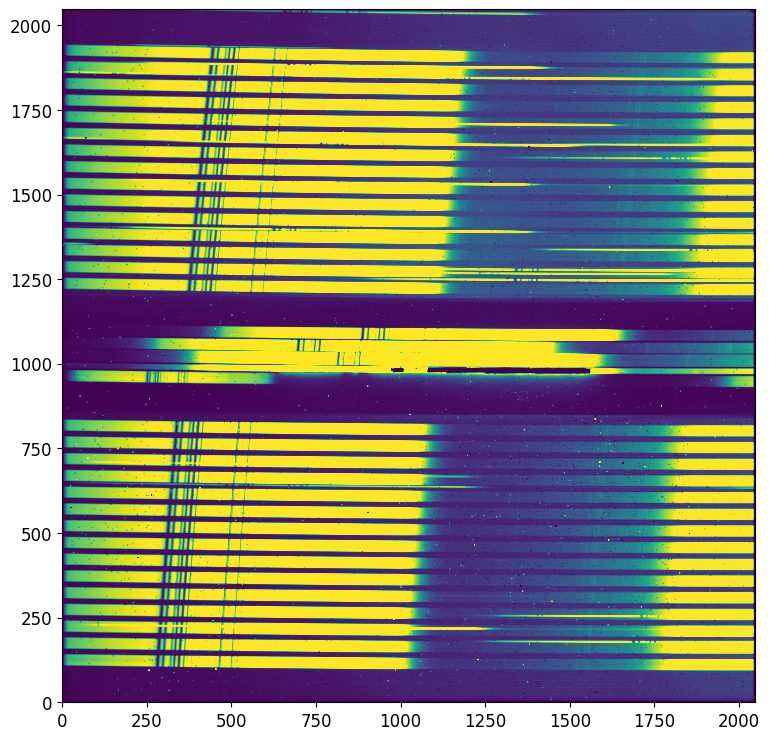

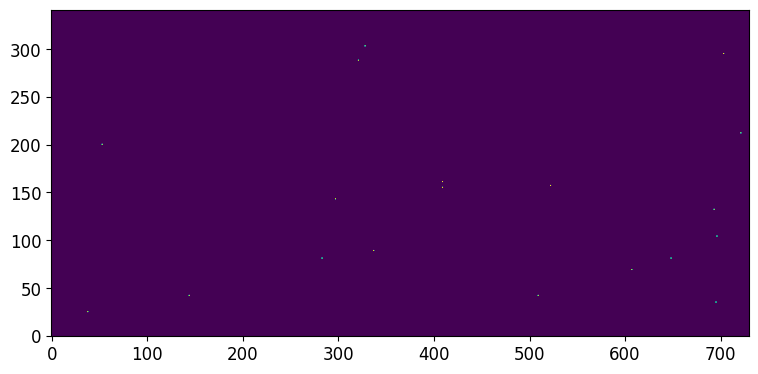

2022-10-06 00:27:41,226 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:27:41,241 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:27:42,037 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<IFUImageModel(2048, 2048) from ifu_g395h_f290lp_nrs1_uncal.fits>,).


2022-10-06 00:27:42,040 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.45, 'slit_y_high': 0.45}


2022-10-06 00:27:42,217 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2022-10-06 00:27:42,278 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1448970586061478 deg


2022-10-06 00:27:42,279 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3232757747173309 deg


2022-10-06 00:27:42,280 - stpipe.AssignWcsStep - INFO - theta_y correction: -3.766823889842878e-13 deg


2022-10-06 00:27:42,282 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:27:42,490 - stpipe.AssignWcsStep - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:27:42,511 - stpipe.AssignWcsStep - INFO - Removing slit 2 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:27:42,587 - stpipe.AssignWcsStep - INFO - Removing slit 6 from the list of open slits because the WCS bounding_box is completely outside the detector.


2022-10-06 00:27:42,830 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


2022-10-06 00:27:42,832 - stpipe.AssignWcsStep - INFO - Computing WCS for 16 open slitlets


2022-10-06 00:27:42,870 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1448970586061478 deg


2022-10-06 00:27:42,871 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3232757747173309 deg


2022-10-06 00:27:42,872 - stpipe.AssignWcsStep - INFO - theta_y correction: -3.766823889842878e-13 deg


2022-10-06 00:27:42,873 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:27:42,889 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2022-10-06 00:27:43,040 - stpipe.AssignWcsStep - INFO - There are 3 open slits in quadrant 1


2022-10-06 00:27:43,066 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 2


2022-10-06 00:27:43,083 - stpipe.AssignWcsStep - INFO - There are 9 open slits in quadrant 3


2022-10-06 00:27:43,156 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 4


2022-10-06 00:27:43,174 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2022-10-06 00:27:43,339 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0005.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0035.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0022.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': 'fopens_metafile_msa.fits'}


2022-10-06 00:27:43,875 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-06 00:27:43,890 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:27:43,890 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done



Working with slit/slice:  3


bounding box rounded to next integer:  [[1859 2048]
 [1638 1646]]
Max value in slity array (ignoring NANs):  0.39354276760554147
percentage of F/O trace that was flagged: 99.6


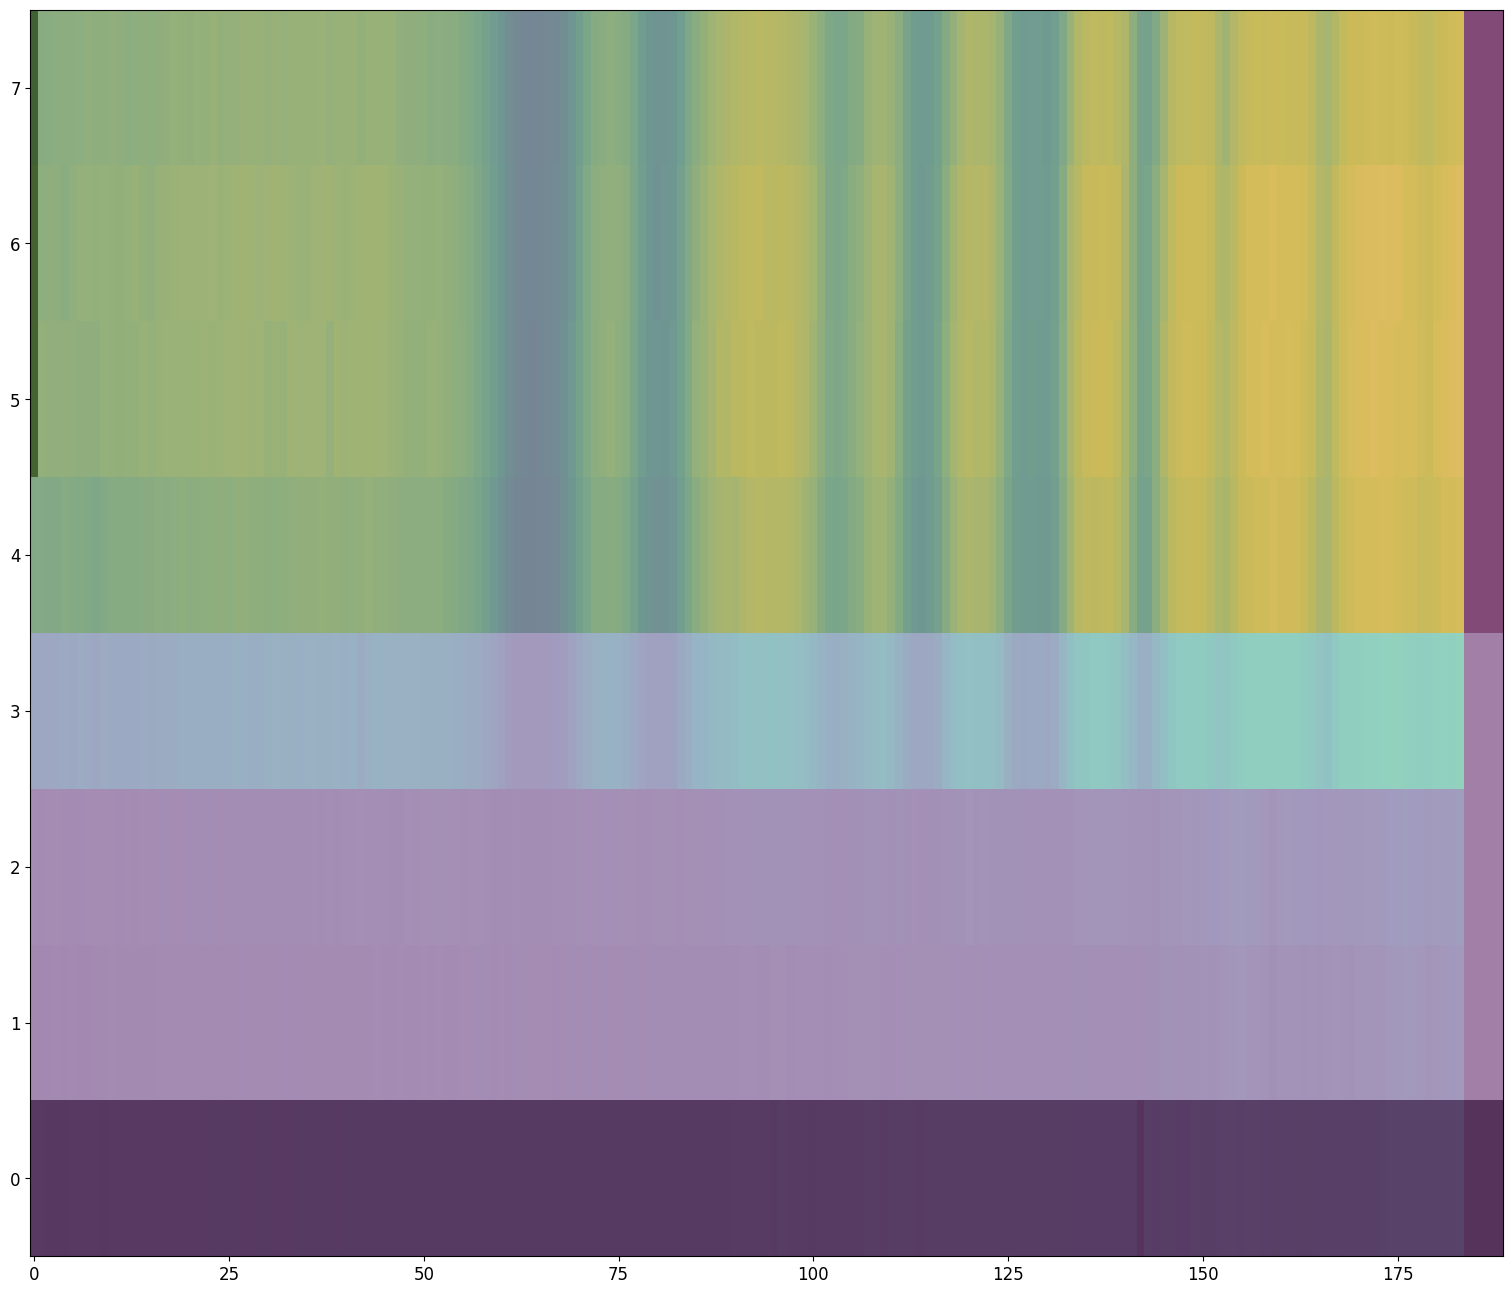


Working with slit/slice:  4


bounding box rounded to next integer:  [[1794 2048]
 [1328 1336]]
Max value in slity array (ignoring NANs):  0.36978689638762896
percentage of F/O trace that was flagged: 99.6


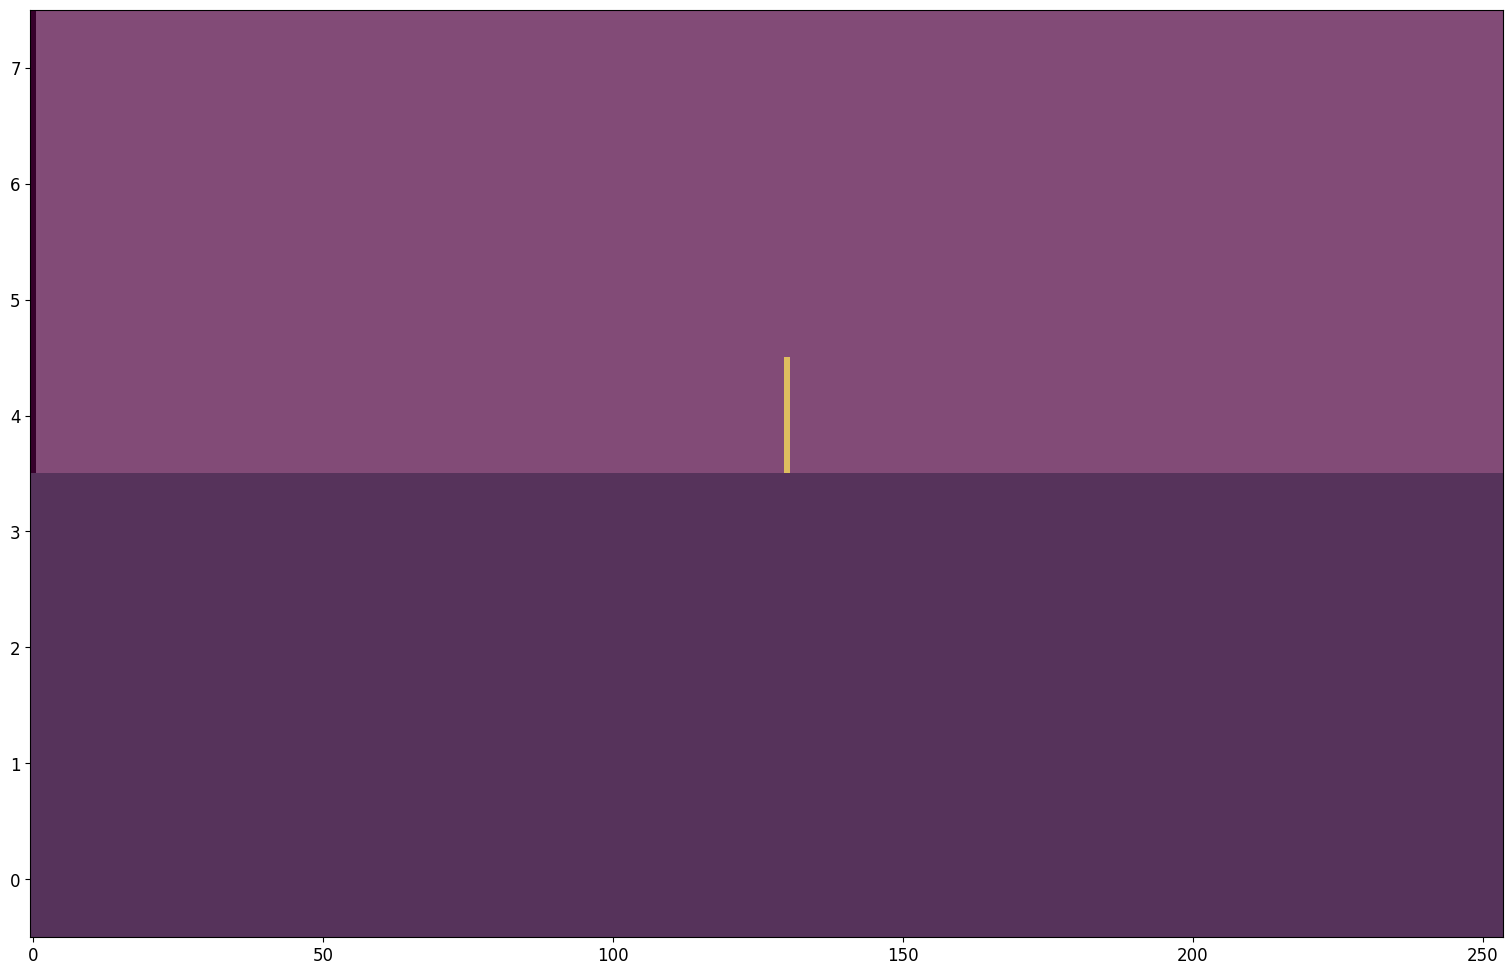


Working with slit/slice:  5


bounding box rounded to next integer:  [[1716 2048]
 [1598 1608]]
Max value in slity array (ignoring NANs):  0.4996419343238408
percentage of F/O trace that was flagged: 100.0


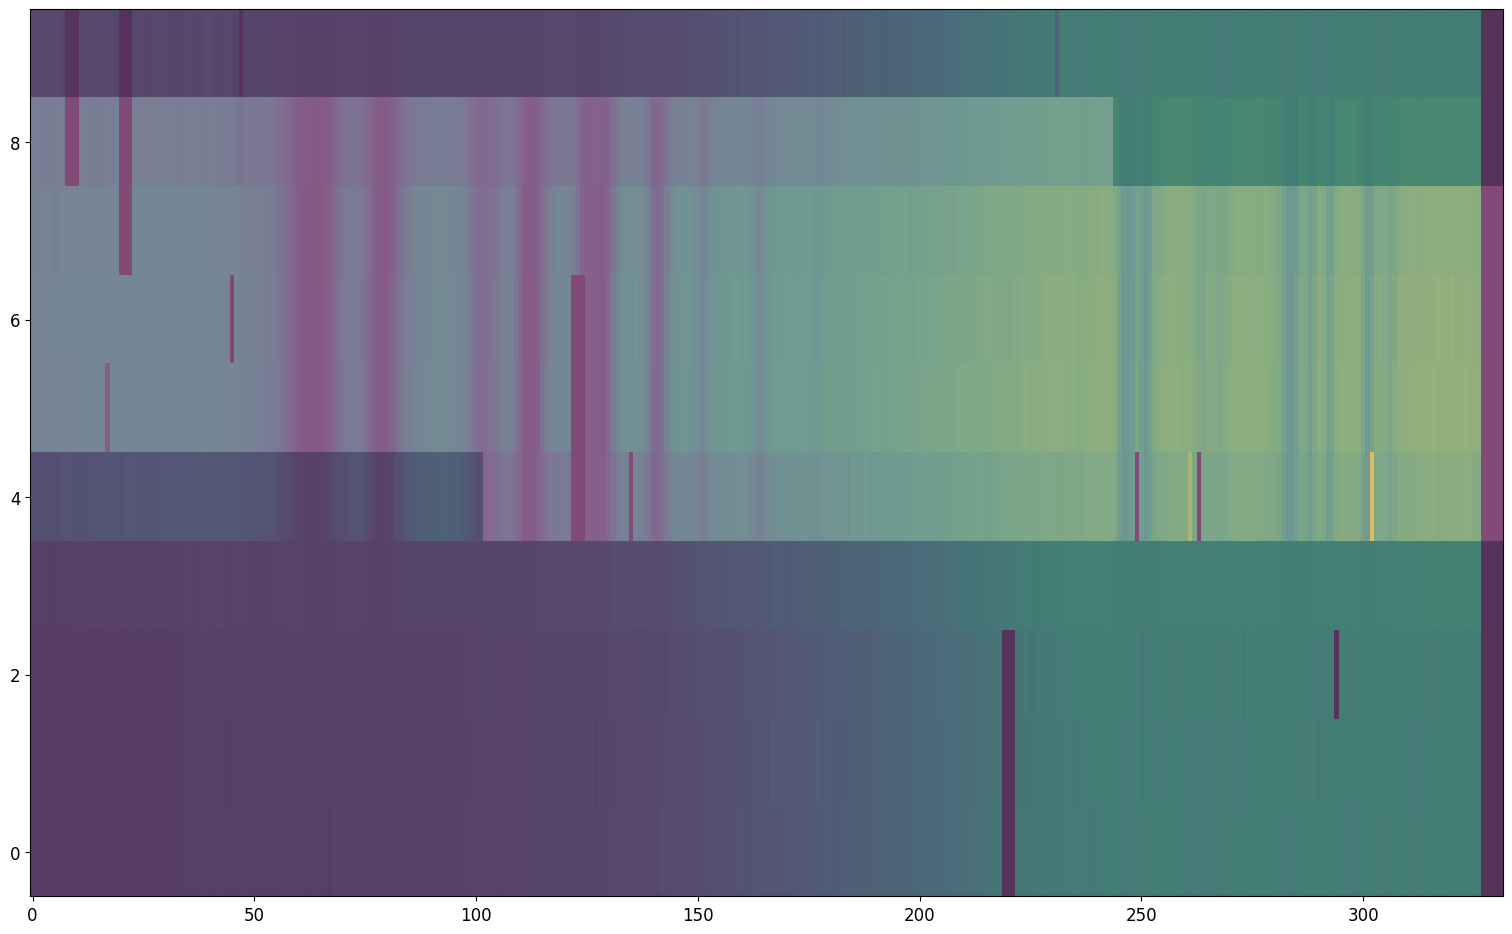


Working with slit/slice:  7


bounding box rounded to next integer:  [[1648 2048]
 [ 246  256]]
Max value in slity array (ignoring NANs):  0.4998979465523029
percentage of F/O trace that was flagged: 99.7


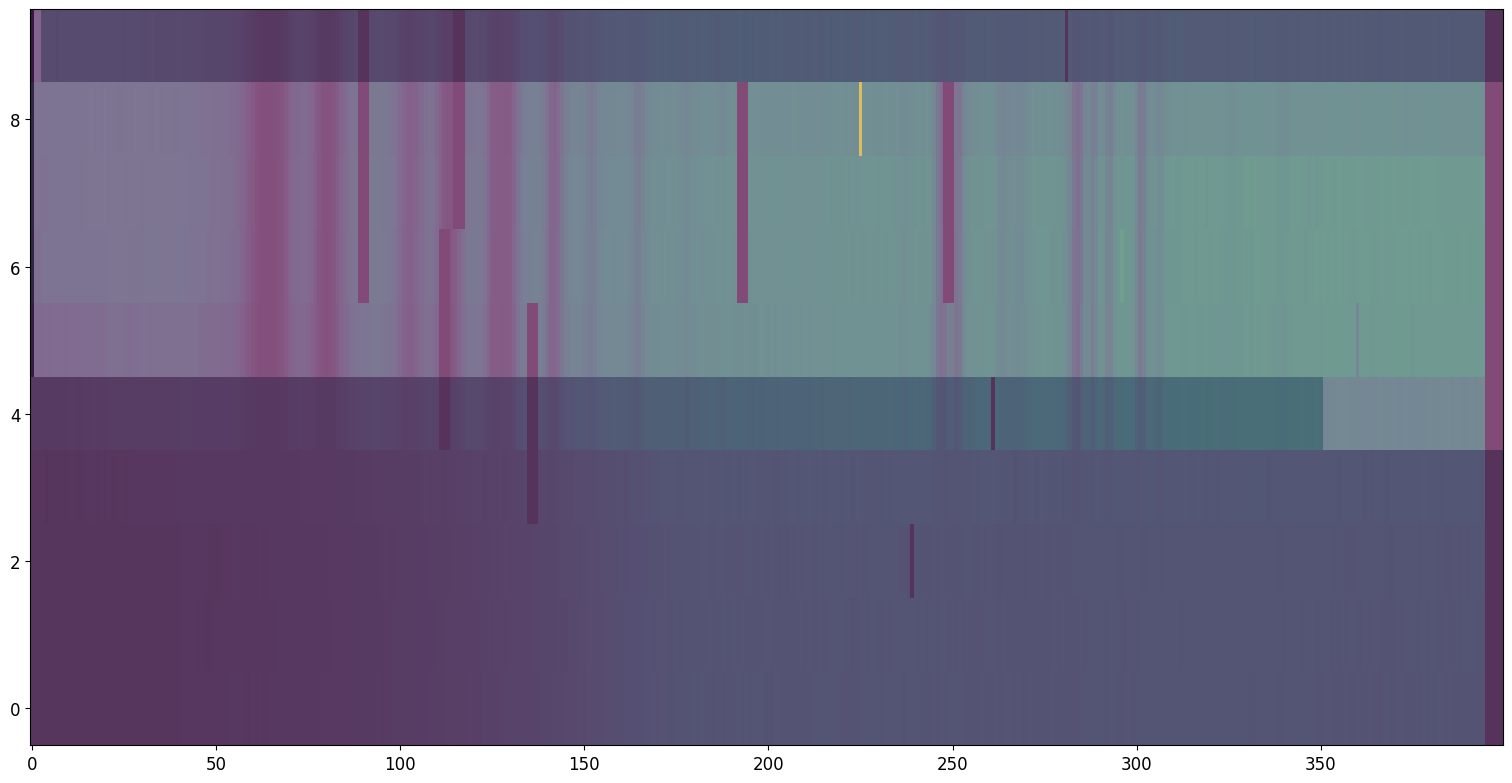


Working with slit/slice:  8


bounding box rounded to next integer:  [[1625 2048]
 [ 172  180]]
Max value in slity array (ignoring NANs):  0.4914901689090161
percentage of F/O trace that was flagged: 100.0


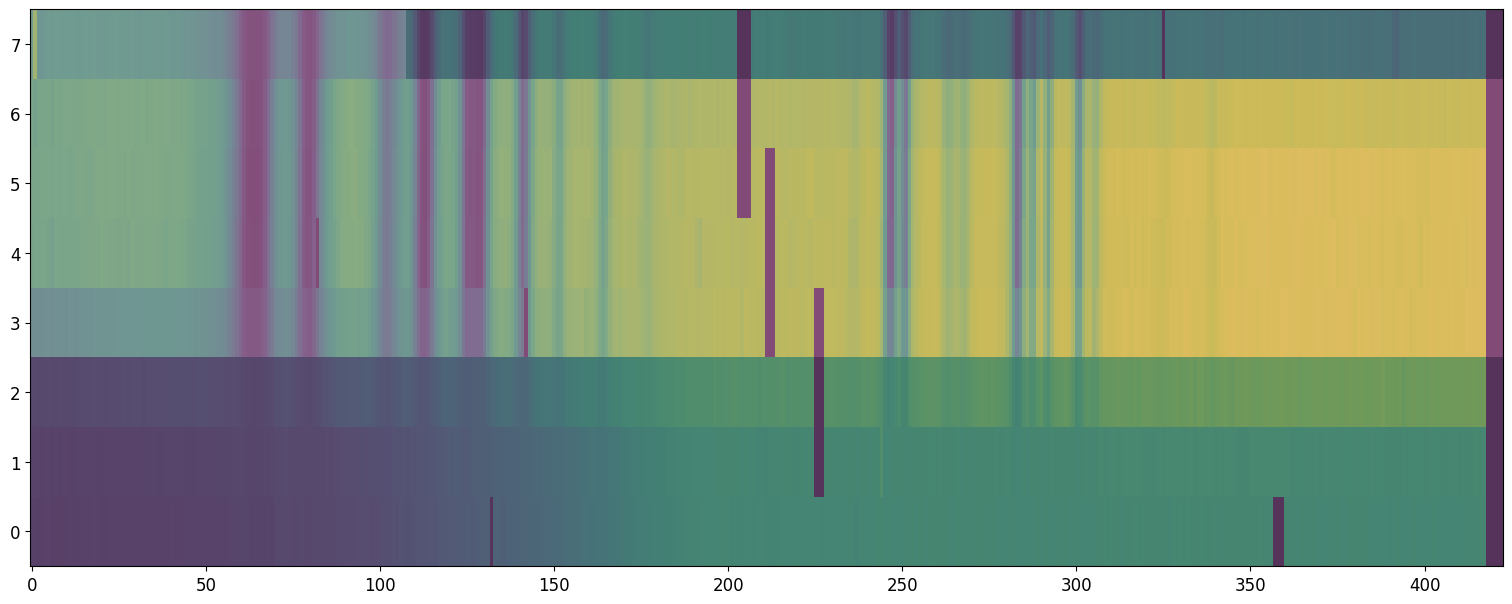


Working with slit/slice:  9
bounding box rounded to next integer:  [[1278 2048]
 [1268 1278]]
Max value in slity array (ignoring NANs):  0.49972222654550663
percentage of F/O trace that was flagged: 99.9


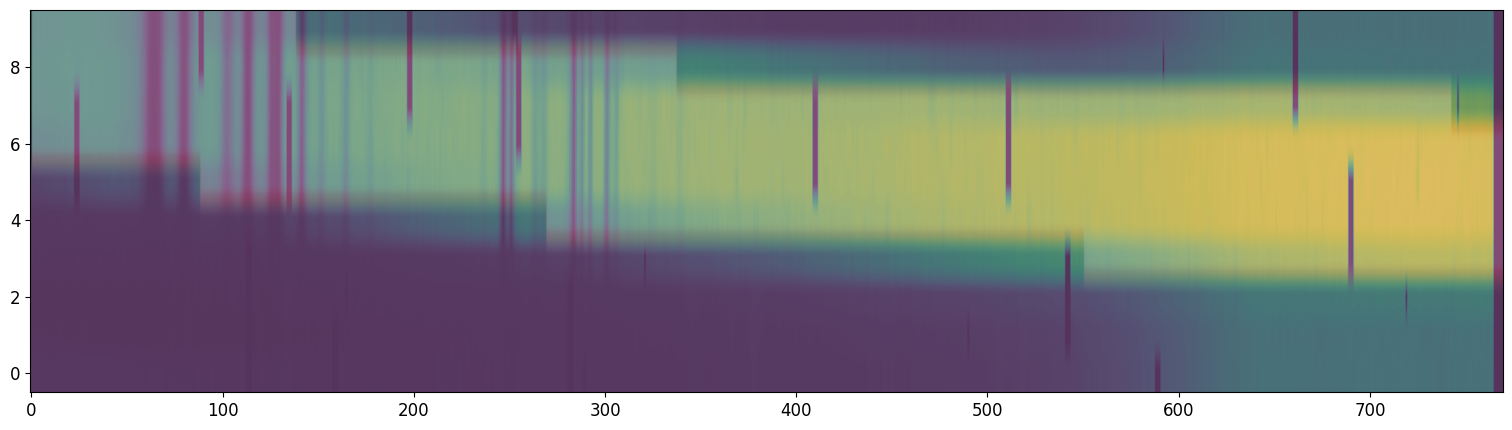


Working with slit/slice:  10


bounding box rounded to next integer:  [[1276 2048]
 [1238 1248]]
Max value in slity array (ignoring NANs):  0.49974965593991627
percentage of F/O trace that was flagged: 100.0


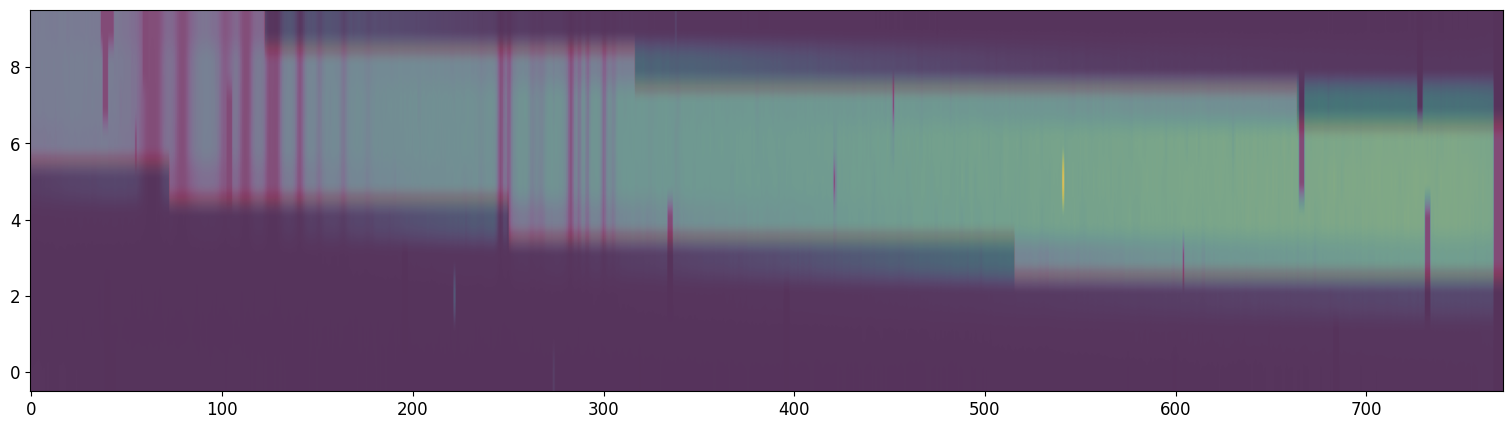


Working with slit/slice:  11


bounding box rounded to next integer:  [[1076 2048]
 [1832 1846]]
Max value in slity array (ignoring NANs):  0.4995125587178428
percentage of F/O trace that was flagged: 99.9


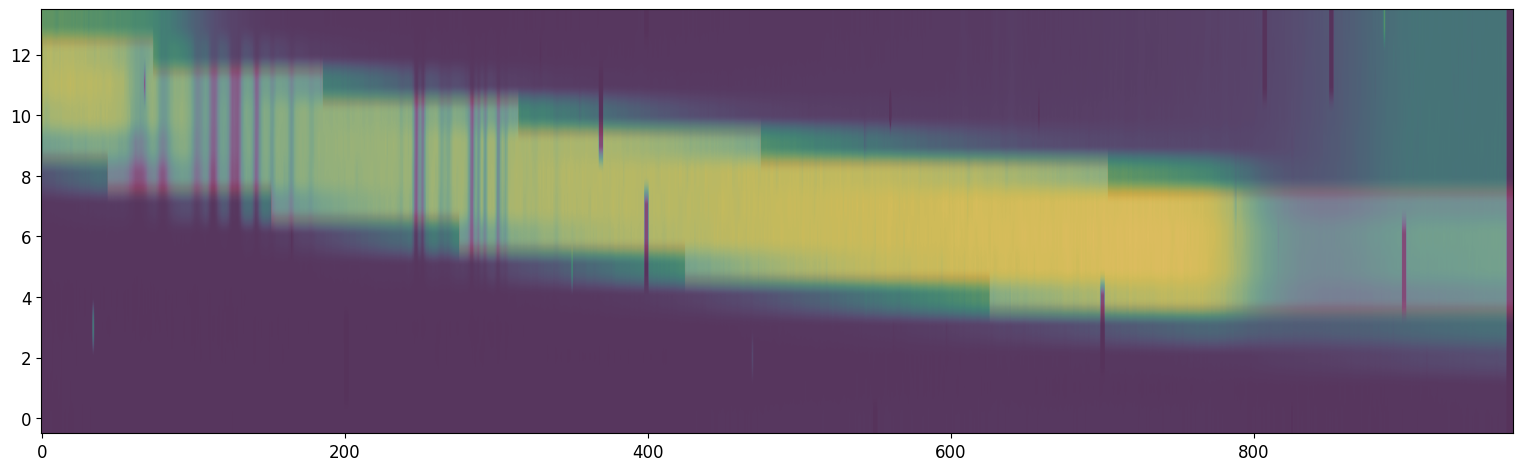


Working with slit/slice:  12
bounding box rounded to next integer:  [[ 987 2048]
 [1256 1270]]


Max value in slity array (ignoring NANs):  0.4998321968363724
percentage of F/O trace that was flagged: 99.9


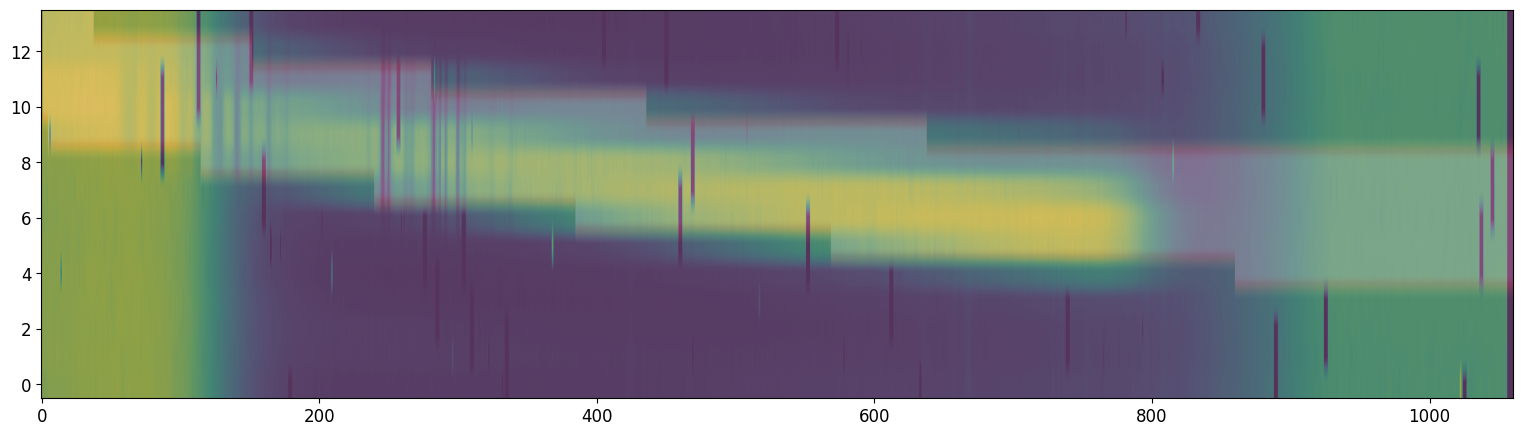


Working with slit/slice:  13


bounding box rounded to next integer:  [[ 812 2048]
 [1696 1712]]
Max value in slity array (ignoring NANs):  0.4997389937798961
percentage of F/O trace that was flagged: 99.9


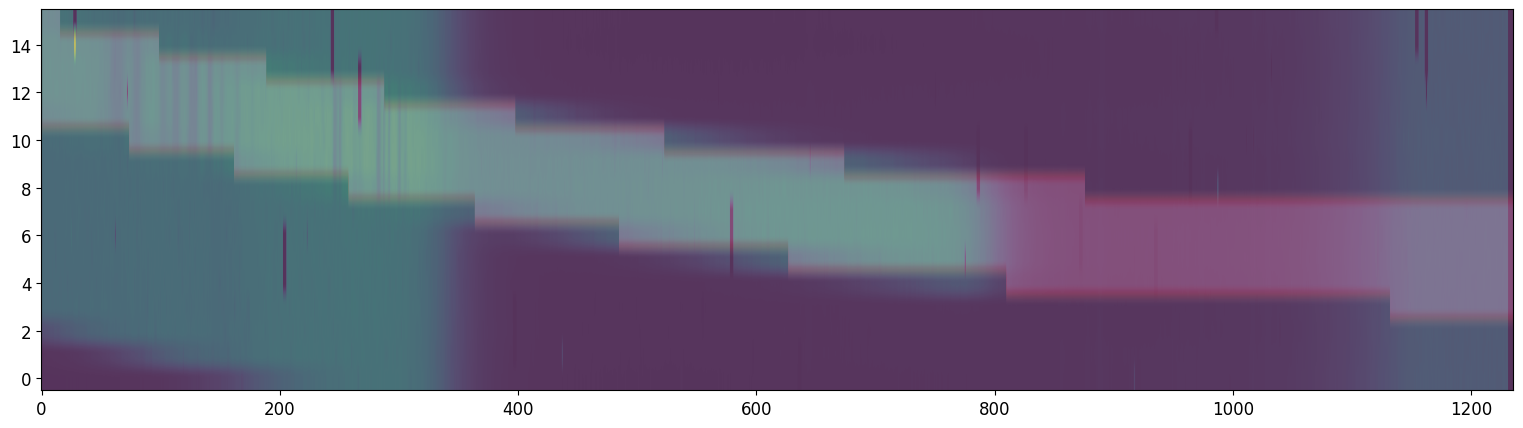


Working with slit/slice:  14


bounding box rounded to next integer:  [[ 702 2048]
 [1636 1652]]
Max value in slity array (ignoring NANs):  0.49993406575349
percentage of F/O trace that was flagged: 100.0


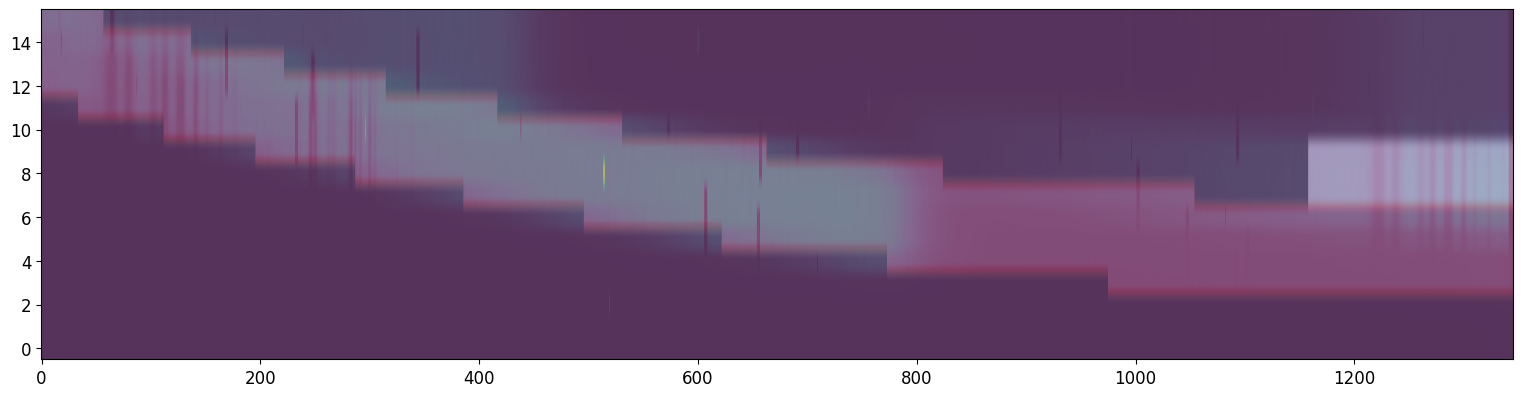


Working with slit/slice:  15
bounding box rounded to next integer:  [[ 562 2048]
 [1380 1398]]
Max value in slity array (ignoring NANs):  0.4999204166968889
percentage of F/O trace that was flagged: 99.9


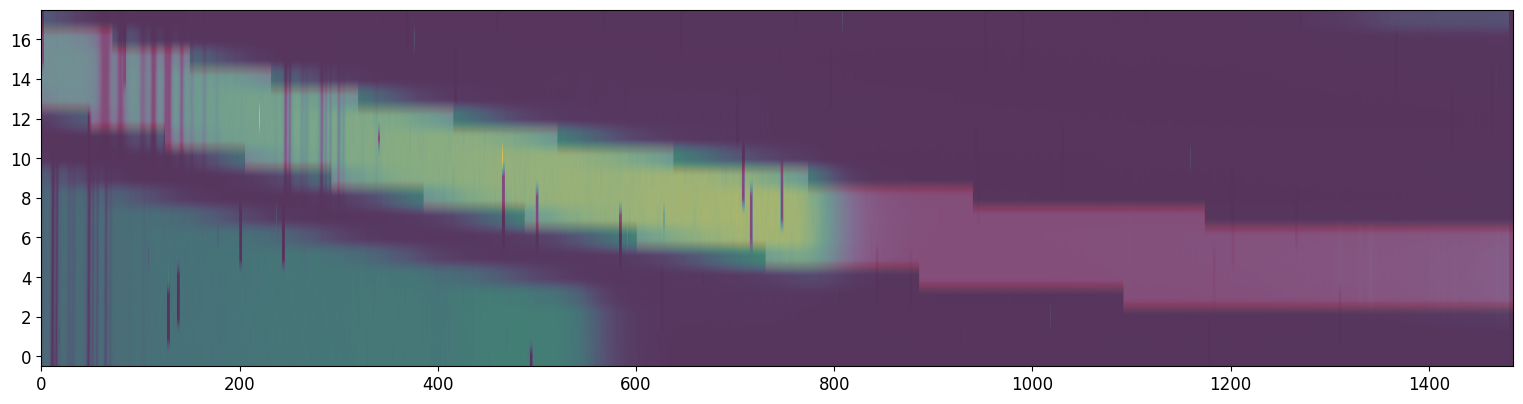


Working with slit/slice:  16


bounding box rounded to next integer:  [[ 606 2048]
 [1864 1884]]
Max value in slity array (ignoring NANs):  0.4997743958906472
percentage of F/O trace that was flagged: 99.9


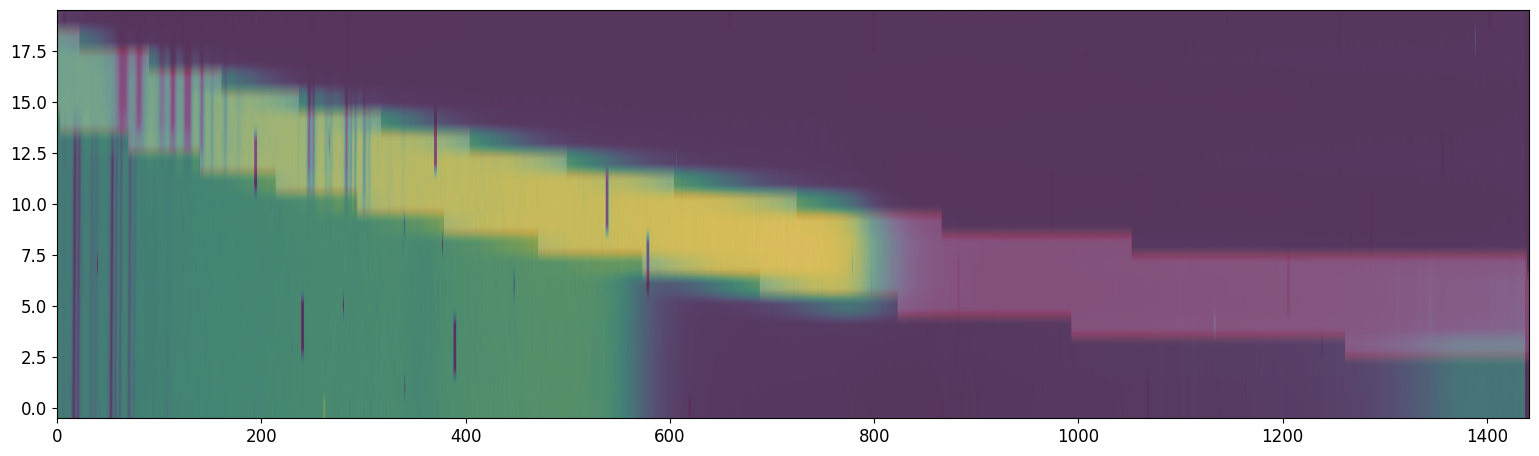


Working with slit/slice:  17
bounding box rounded to next integer:  [[ 568 2048]
 [1520 1538]]
Max value in slity array (ignoring NANs):  0.4999226887144772
percentage of F/O trace that was flagged: 99.9


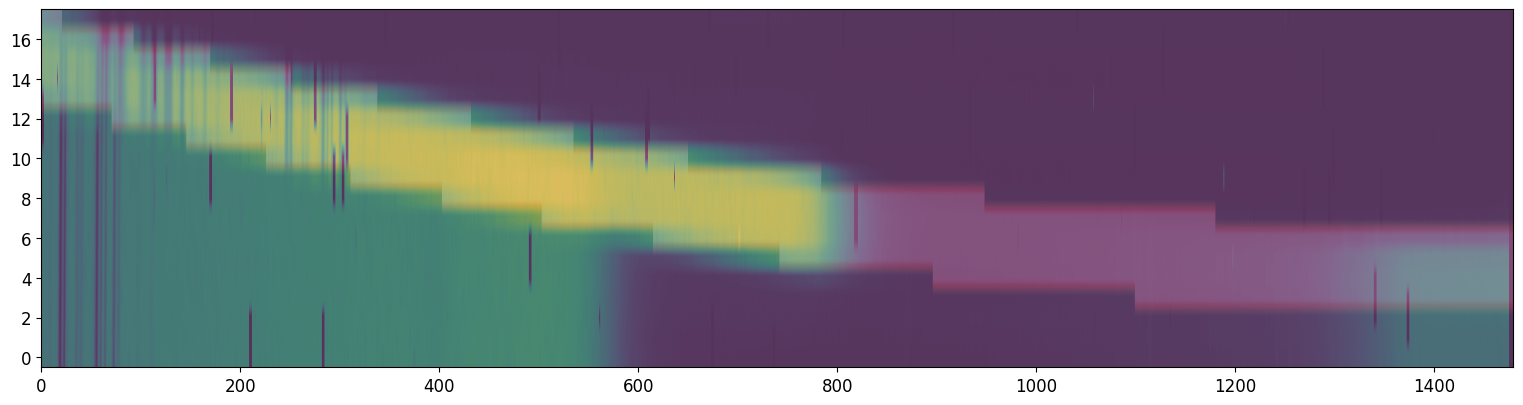


Working with slit/slice:  18


bounding box rounded to next integer:  [[ 437 2048]
 [ 208  226]]
Max value in slity array (ignoring NANs):  0.4999158219759617
percentage of F/O trace that was flagged: 99.9


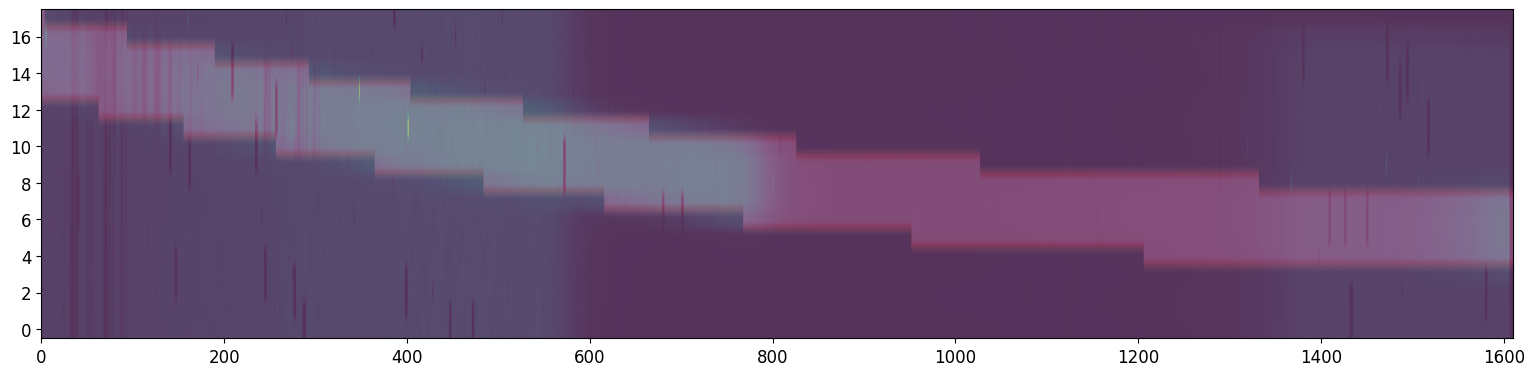


Working with slit/slice:  19
bounding box rounded to next integer:  [[ 424 2048]
 [ 626  646]]
Max value in slity array (ignoring NANs):  0.49974363642795727
percentage of F/O trace that was flagged: 99.9


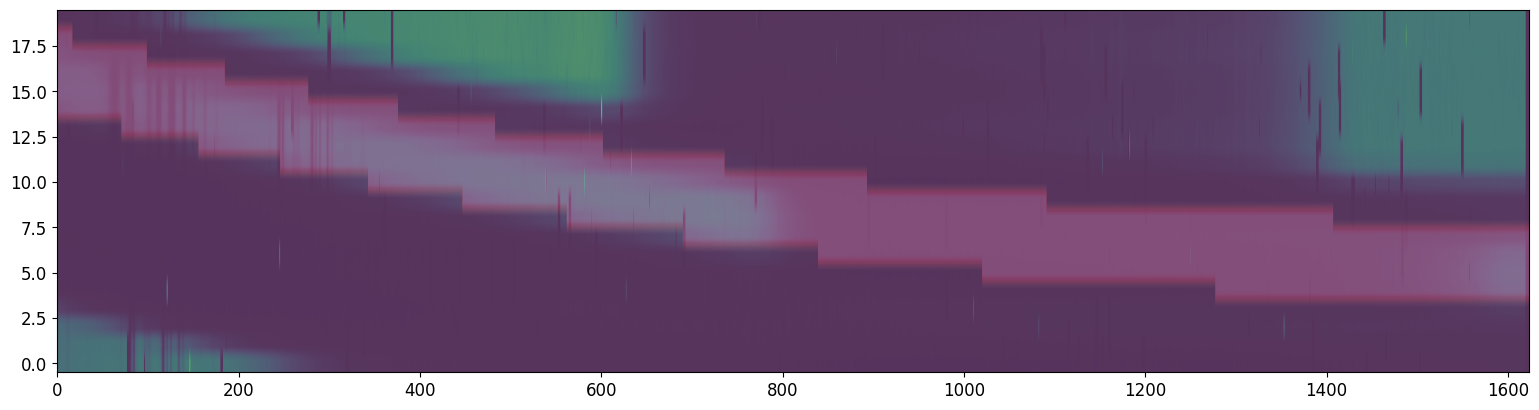


 *** Final result for msa_flagging test will be reported as PASSED *** 

('* MSA flagging validation test took ', '18.520240545272827 seconds to finish.')
Did msa_flagging validation test pass?  True 


Testing files for detector:  nrs2


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v/ifu_g395h_f290lp_nrs2_uncal.fits


2022-10-06 00:28:01,392 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0004.asdf


2022-10-06 00:28:01,411 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-06 00:28:01,413 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-06 00:28:01,414 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-06 00:28:01,415 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-06 00:28:01,417 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-06 00:28:01,418 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-06 00:28:01,419 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-06 00:28:01,420 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-06 00:28:01,421 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-06 00:28:01,422 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-06 00:28:01,423 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-06 00:28:01,424 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-06 00:28:01,425 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-06 00:28:01,426 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-06 00:28:01,427 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-06 00:28:01,428 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-06 00:28:01,429 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-06 00:28:01,698 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v/ifu_g395h_f290lp_nrs2_uncal.fits',).


2022-10-06 00:28:01,709 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-10-06 00:28:02,082 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'ifu_g395h_f290lp_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-06 00:28:02,096 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0085.fits'.


2022-10-06 00:28:02,097 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0020.fits'.


2022-10-06 00:28:02,099 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0025.fits'.


2022-10-06 00:28:02,100 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0011.fits'.


2022-10-06 00:28:02,102 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-06 00:28:02,102 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits'.


2022-10-06 00:28:02,103 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_refpix_0018.fits'.


2022-10-06 00:28:02,105 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-06 00:28:02,105 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2022-10-06 00:28:02,106 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0026.fits'.


2022-10-06 00:28:02,107 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0118.fits'.


2022-10-06 00:28:02,109 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-06 00:28:02,109 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-06 00:28:02,110 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-06 00:28:02,989 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:28:02,991 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:28:03,481 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-06 00:28:03,482 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-06 00:28:03,485 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-06 00:28:03,686 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:28:03,688 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:28:03,711 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0011.fits


2022-10-06 00:28:04,532 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-06 00:28:04,748 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:28:04,749 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v', 'n_pix_grow_sat': 1}


2022-10-06 00:28:04,773 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0026.fits


2022-10-06 00:28:09,871 - stpipe.Detector1Pipeline.saturation - INFO - Detected 224463 saturated pixels


2022-10-06 00:28:10,027 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-06 00:28:10,050 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-06 00:28:10,254 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:28:10,255 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:28:10,256 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-06 00:28:10,259 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-06 00:28:10,456 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:28:10,458 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:28:10,484 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0118.fits


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.readpatt the following error occurred:
'ALLIRS2' is not one of ['ACQ1', 'ACQ2', 'BRIGHT1', 'BRIGHT2', 'DEEP2', 'DEEP8', 'FAST', 'FASTGRPAVG', 'FASTGRPAVG8', 'FASTGRPAVG16', 'FASTGRPAVG32', 'FASTGRPAVG64', 'FASTR1', 'FASTR100', 'FGS', 'FGS60', 'FGS8370', 'FGS840', 'FGSRAPID', 'FINEGUIDE', 'ID', 'MEDIUM2', 'MEDIUM8', 'NIS', 'NISRAPID', 'NRS', 'NRSIRS2', 'NRSN16R4', 'NRSN32R8', 'NRSN8R2', 'NRSRAPID', 'NRSIRS2RAPID', 'NRSRAPIDD1', 'NRSRAPIDD2', 'NRSRAPIDD6', 'NRSSLOW', 'RAPID', 'SHALLOW2', 'SHALLOW4', 'SLOW', 'SLOWR1', 'TRACK', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Readout pattern'),
                 ('type', 'string'),
                 ('enum',
                  ['ACQ1',
                   'ACQ2',
                   'B

2022-10-06 00:28:14,474 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-06 00:28:14,825 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:28:14,827 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-06 00:28:14,858 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /grp/crds/cache/references/jwst/jwst_nirspec_refpix_0018.fits


2022-10-06 00:28:17,415 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1


2022-10-06 00:29:23,270 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-06 00:29:23,839 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:29:23,841 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:29:23,875 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0025.fits


2022-10-06 00:29:25,580 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-06 00:29:27,425 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-06 00:29:27,797 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:29:27,798 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v', 'dark_output': None}


2022-10-06 00:29:28,105 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0085.fits


2022-10-06 00:29:57,563 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=20, nframes=1, groupgap=0


2022-10-06 00:29:57,564 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=65, nframes=1, groupgap=0


2022-10-06 00:29:59,084 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-06 00:29:59,349 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:29:59,351 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-06 00:29:59,505 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-06 00:29:59,676 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0020.fits


2022-10-06 00:30:00,274 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits


2022-10-06 00:30:01,384 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-06 00:30:01,601 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)


2022-10-06 00:30:09,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 68624 pixels with at least one CR from five or more groups.


2022-10-06 00:30:09,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 408 pixels with at least one CR from four groups.


2022-10-06 00:30:09,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36 pixels with at least one CR from three groups.


2022-10-06 00:30:33,385 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 31.9994 sec


2022-10-06 00:30:33,389 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 33.883233


2022-10-06 00:30:33,394 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-06 00:30:33,742 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 20, 3200, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:30:33,745 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-06 00:30:34,194 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0017.fits


2022-10-06 00:30:34,195 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0020.fits


2022-10-06 00:30:34,297 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-06 00:30:34,298 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-06 00:33:17,630 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 20


2022-10-06 00:33:17,631 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 1


2022-10-06 00:33:17,840 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-06 00:33:18,216 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(2048, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:33:18,218 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:33:18,278 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2022-10-06 00:33:18,294 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 00:33:18,474 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:33:18,475 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmphvi0sk4v'}


2022-10-06 00:33:18,540 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2022-10-06 00:33:18,557 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-06 00:33:18,558 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-06 00:33:18,558 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:33:18,559 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-06 00:33:18,570 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:33:18,751 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<IFUImageModel(2048, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:33:18,752 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-06 00:33:18,952 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1448970586061478 deg


2022-10-06 00:33:18,953 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3232757747173309 deg


2022-10-06 00:33:18,954 - stpipe.AssignWcsStep - INFO - theta_y correction: -3.766823889842878e-13 deg


2022-10-06 00:33:18,956 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:33:22,390 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_ifu pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0005.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0035.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0022.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': '/grp/crds/cache/references/jwst/jwst_nirspec_ifupost_0004.asdf', 'ifufore': '/grp/crds/cache/references/jwst/jwst_nirspec_ifufore_0003.asdf', 'ifuslicer': '/grp/crds/cache/references/jwst/jwst_n

2022-10-06 00:33:29,246 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  156.176996289 -45.687617183 156.178772625 -45.687617183 156.178772625 -45.686330364 156.176996289 -45.686330364


2022-10-06 00:33:29,249 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-06 00:33:29,264 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:33:29,265 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2022-10-06 00:33:29,277 - stpipe.MSAFlagOpenStep - INFO - MSAFlagOpenStep instance created.


2022-10-06 00:33:29,625 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep running with args (<IFUImageModel(2048, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:33:29,627 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-06 00:33:29,648 - stpipe.MSAFlagOpenStep - INFO - Using reference file /grp/crds/cache/references/jwst/jwst_nirspec_msaoper_0001.json


2022-10-06 00:33:29,649 - stpipe.JwstStep - INFO - JwstStep instance created.


2022-10-06 00:33:29,772 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.1448970586061478 deg


2022-10-06 00:33:29,773 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3232757747173309 deg


2022-10-06 00:33:29,774 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: -3.766823889842878e-13 deg


2022-10-06 00:33:29,775 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:33:29,791 - stpipe.MSAFlagOpenStep - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2022-10-06 00:33:29,940 - stpipe.MSAFlagOpenStep - INFO - There are 5 open slits in quadrant 1


2022-10-06 00:33:29,979 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2


2022-10-06 00:33:30,003 - stpipe.MSAFlagOpenStep - INFO - There are 9 open slits in quadrant 3


2022-10-06 00:33:30,072 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 4


2022-10-06 00:33:30,097 - stpipe.MSAFlagOpenStep - INFO - There are 0 open slits in quadrant 5


2022-10-06 00:33:44,929 - stpipe.MSAFlagOpenStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:33:44,931 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep done


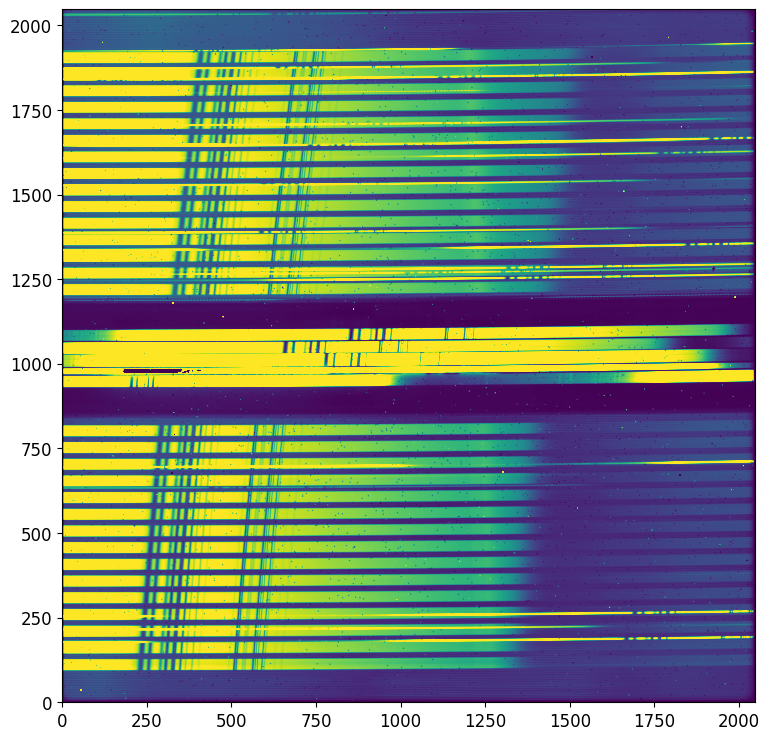

2022-10-06 00:33:45,669 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:33:45,683 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2022-10-06 00:33:46,382 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<IFUImageModel(2048, 2048) from ifu_g395h_f290lp_nrs2_uncal.fits>,).


2022-10-06 00:33:46,384 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.45, 'slit_y_high': 0.45}


2022-10-06 00:33:46,547 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1


2022-10-06 00:33:46,605 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1448970586061478 deg


2022-10-06 00:33:46,606 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3232757747173309 deg


2022-10-06 00:33:46,606 - stpipe.AssignWcsStep - INFO - theta_y correction: -3.766823889842878e-13 deg


2022-10-06 00:33:46,608 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:33:47,143 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


2022-10-06 00:33:47,144 - stpipe.AssignWcsStep - INFO - Computing WCS for 19 open slitlets


2022-10-06 00:33:47,180 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1448970586061478 deg


2022-10-06 00:33:47,181 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3232757747173309 deg


2022-10-06 00:33:47,182 - stpipe.AssignWcsStep - INFO - theta_y correction: -3.766823889842878e-13 deg


2022-10-06 00:33:47,183 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg


2022-10-06 00:33:47,198 - stpipe.AssignWcsStep - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2022-10-06 00:33:47,346 - stpipe.AssignWcsStep - INFO - There are 5 open slits in quadrant 1


2022-10-06 00:33:47,385 - stpipe.AssignWcsStep - INFO - There are 3 open slits in quadrant 2


2022-10-06 00:33:47,409 - stpipe.AssignWcsStep - INFO - There are 9 open slits in quadrant 3


2022-10-06 00:33:47,479 - stpipe.AssignWcsStep - INFO - There are 2 open slits in quadrant 4


2022-10-06 00:33:47,495 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5


2022-10-06 00:33:47,655 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0005.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0035.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0022.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafile': 'fopens_metafile_msa.fits'}


2022-10-06 00:33:48,192 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2022-10-06 00:33:48,207 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-06 00:33:48,207 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done



Working with slit/slice:  1


bounding box rounded to next integer:  [[ 331 2048]
 [1914 1946]]
Max value in slity array (ignoring NANs):  0.4998831147473369
percentage of F/O trace that was flagged: 100.0


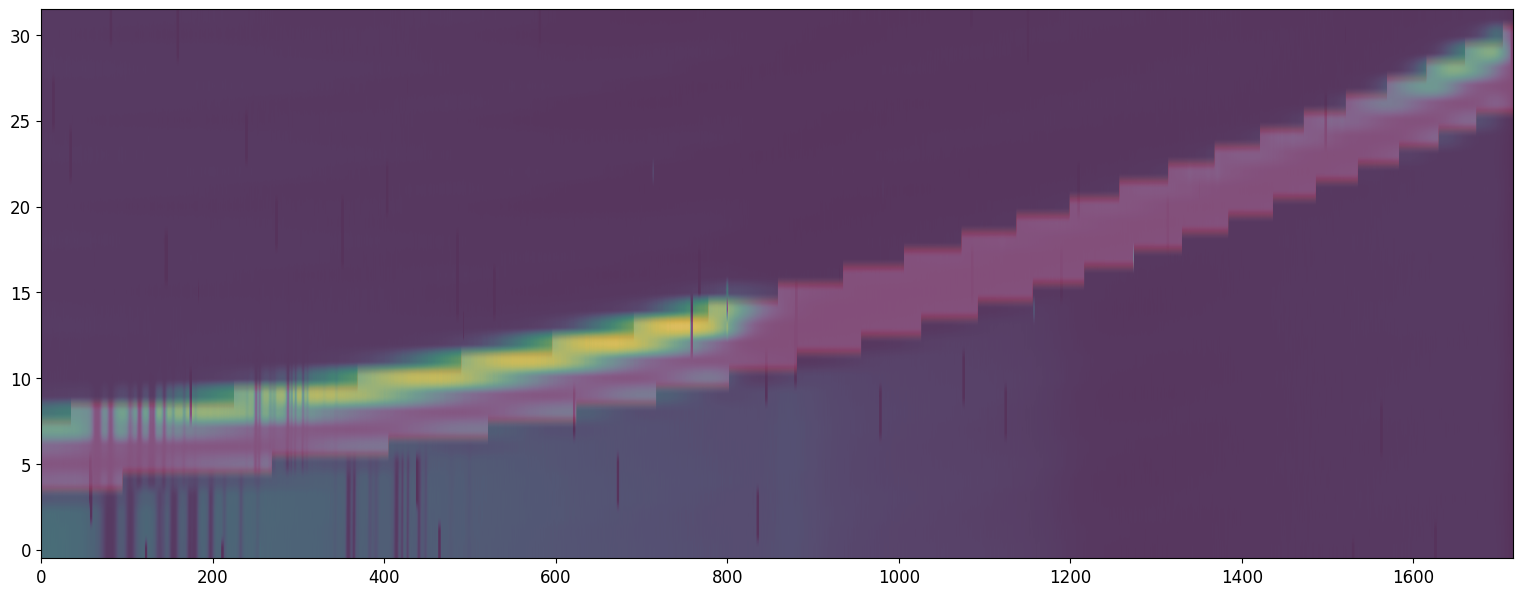


Working with slit/slice:  2


bounding box rounded to next integer:  [[  46 2048]
 [1832 1862]]
Max value in slity array (ignoring NANs):  0.49994239693485726
percentage of F/O trace that was flagged: 100.0


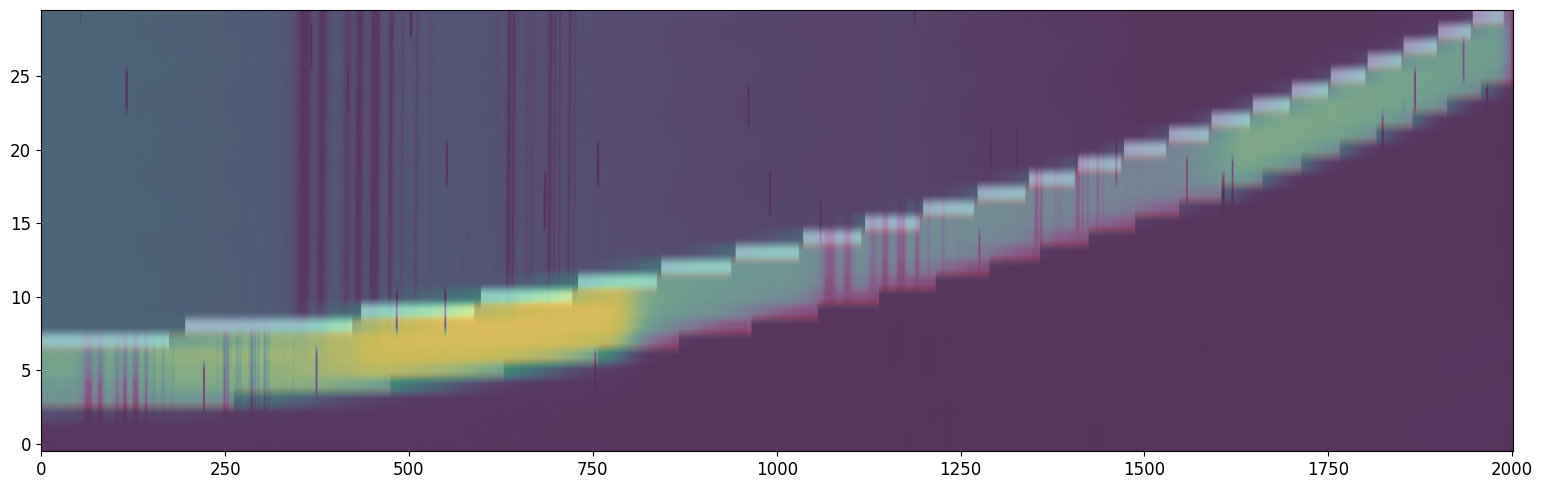


Working with slit/slice:  3


bounding box rounded to next integer:  [[   0 2048]
 [1638 1668]]
Max value in slity array (ignoring NANs):  0.49992568371104673
percentage of F/O trace that was flagged: 100.0


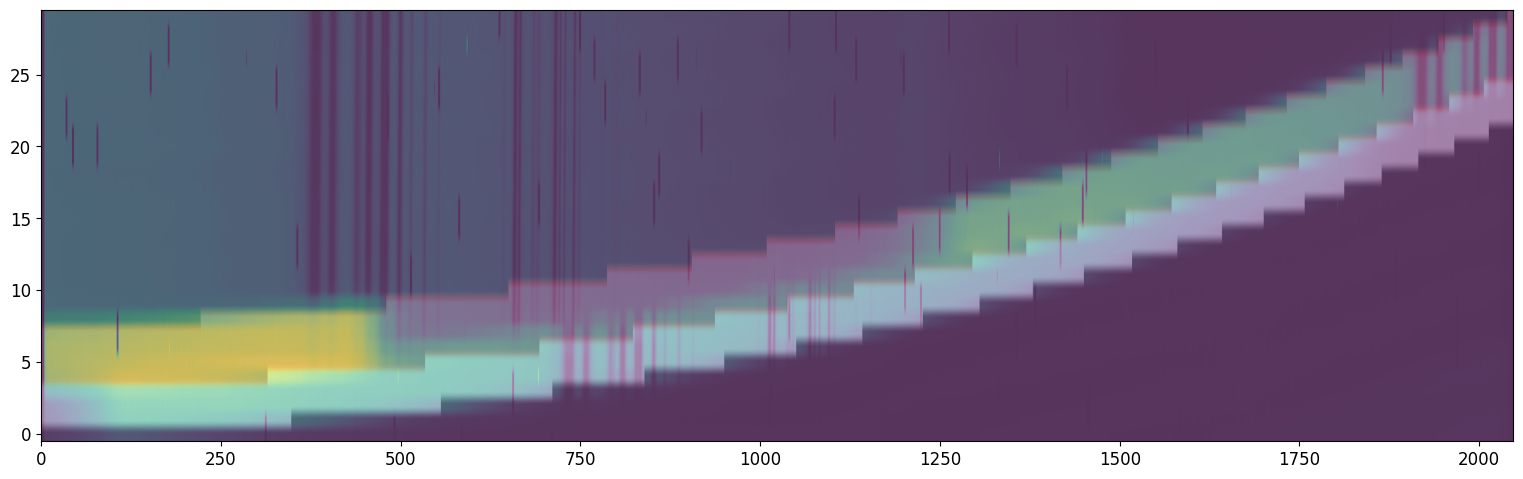


Working with slit/slice:  4


bounding box rounded to next integer:  [[   0 2048]
 [1328 1356]]
Max value in slity array (ignoring NANs):  0.49997225701044107
percentage of F/O trace that was flagged: 100.0


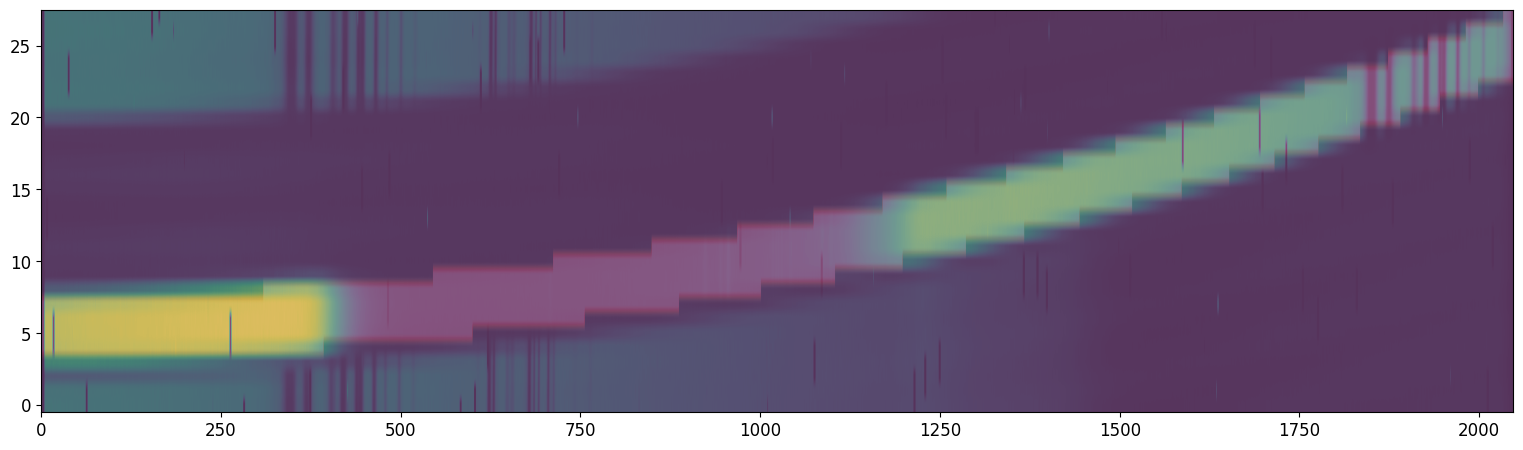


Working with slit/slice:  5


bounding box rounded to next integer:  [[   0 2048]
 [1598 1628]]
Max value in slity array (ignoring NANs):  0.49996521163224844
percentage of F/O trace that was flagged: 100.0


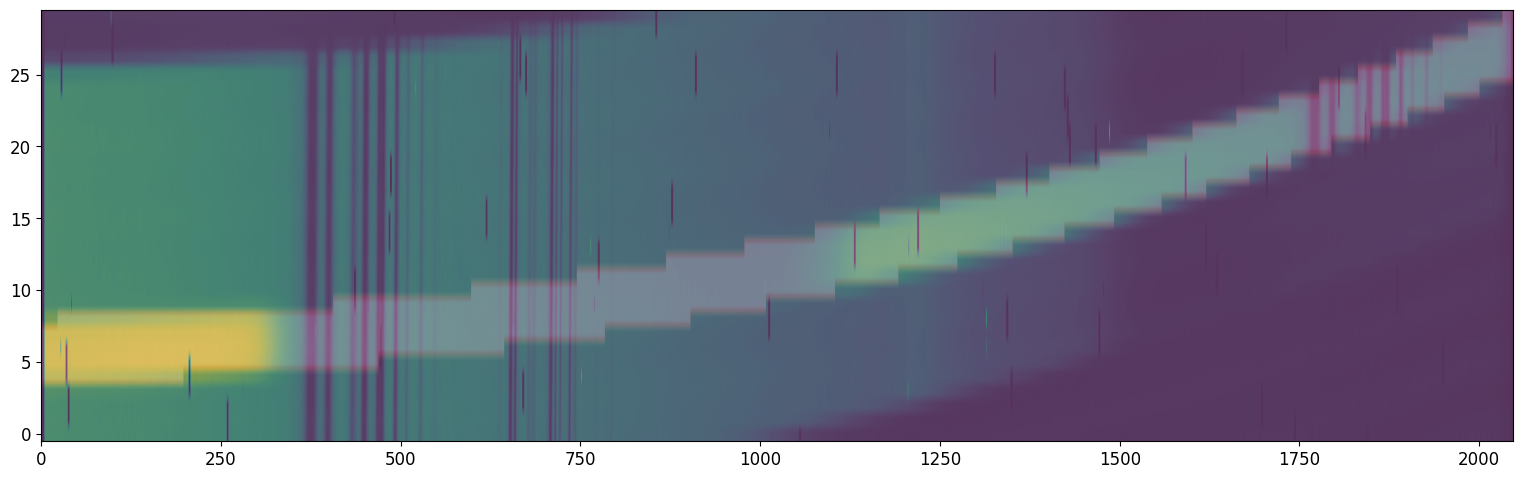


Working with slit/slice:  6


bounding box rounded to next integer:  [[ 188 2048]
 [ 688  712]]
Max value in slity array (ignoring NANs):  0.49982756864902916
percentage of F/O trace that was flagged: 99.9


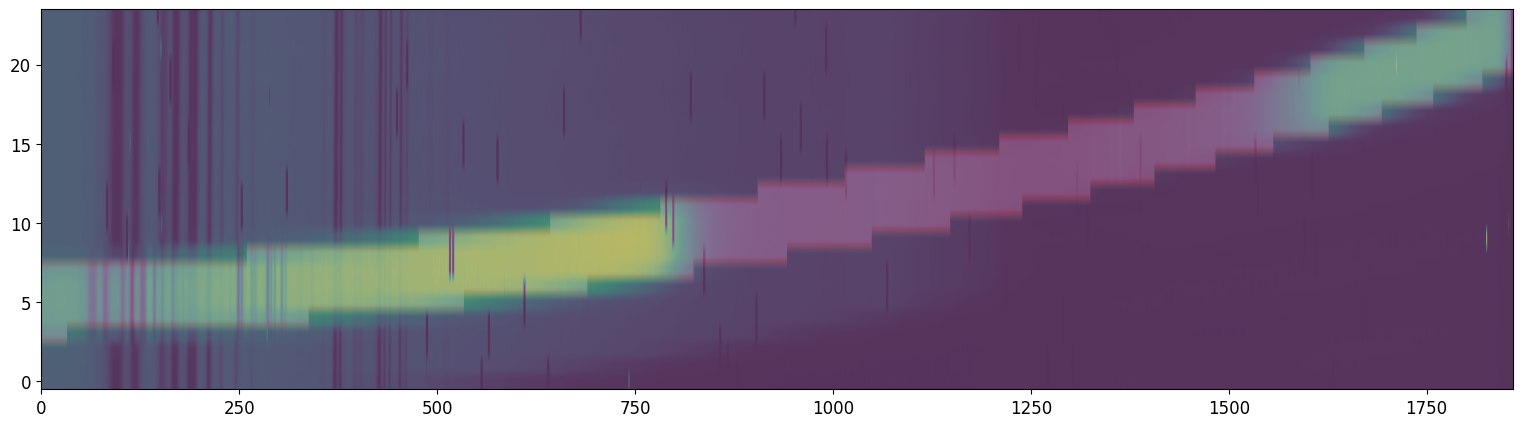


Working with slit/slice:  7


bounding box rounded to next integer:  [[   0 2048]
 [ 248  270]]
Max value in slity array (ignoring NANs):  0.49952809423454014
percentage of F/O trace that was flagged: 100.0


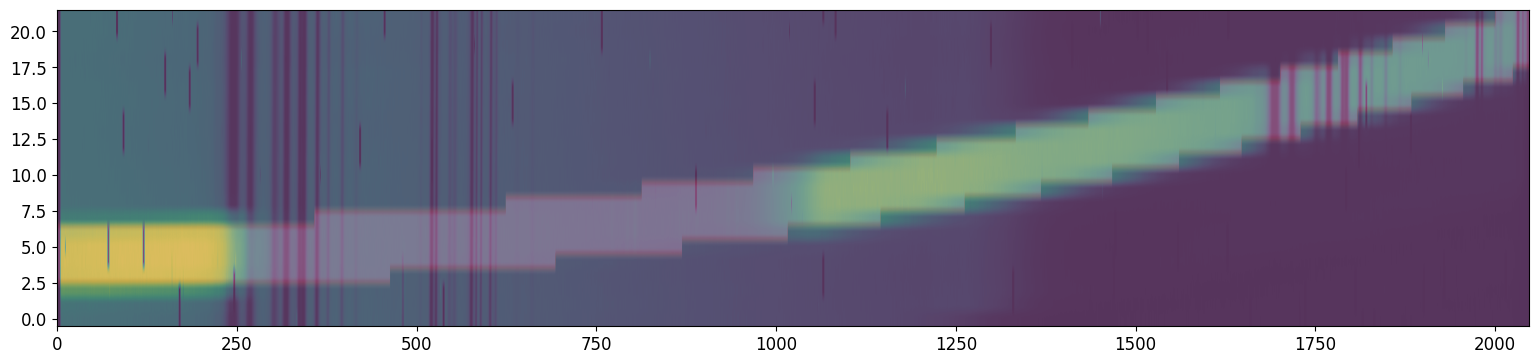


Working with slit/slice:  8


bounding box rounded to next integer:  [[   0 2048]
 [ 172  194]]
Max value in slity array (ignoring NANs):  0.4999761295693984
percentage of F/O trace that was flagged: 100.0


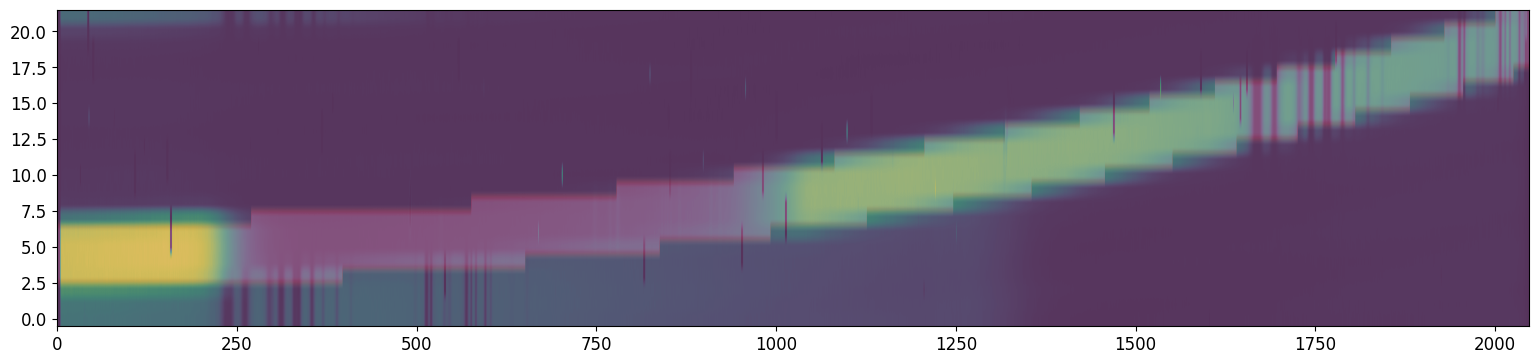


Working with slit/slice:  9


bounding box rounded to next integer:  [[   0 2048]
 [1268 1296]]
Max value in slity array (ignoring NANs):  0.49986787703942764
percentage of F/O trace that was flagged: 100.0


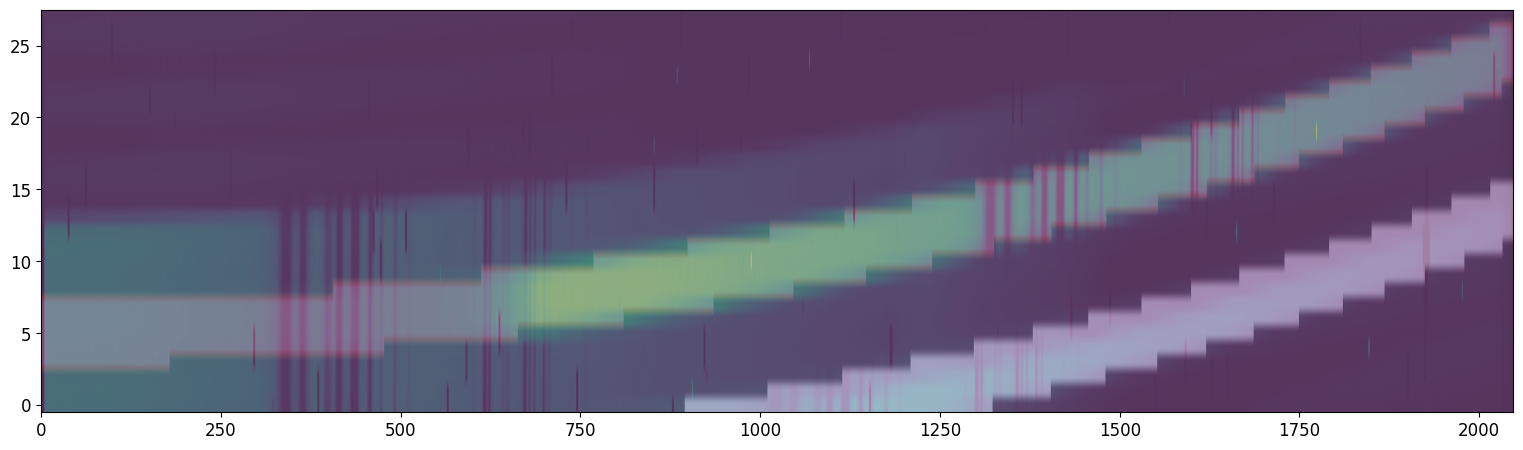


Working with slit/slice:  10


bounding box rounded to next integer:  [[   0 2048]
 [1238 1266]]
Max value in slity array (ignoring NANs):  0.4999627619280446
percentage of F/O trace that was flagged: 100.0


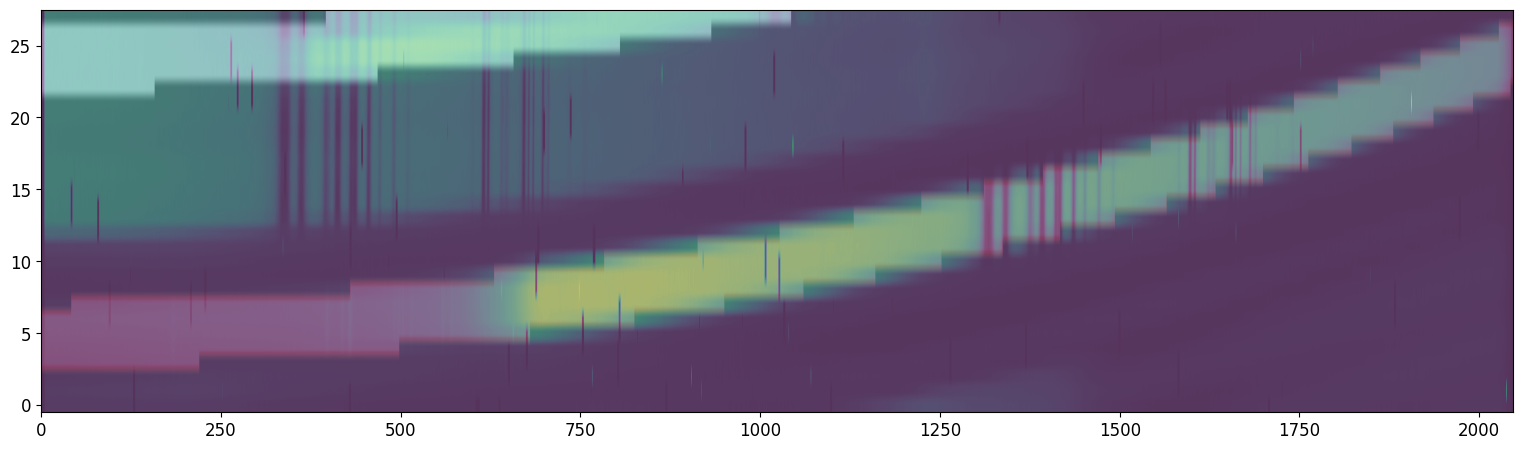


Working with slit/slice:  11


bounding box rounded to next integer:  [[   0 2048]
 [1832 1864]]
Max value in slity array (ignoring NANs):  0.49986310206990686
percentage of F/O trace that was flagged: 100.0


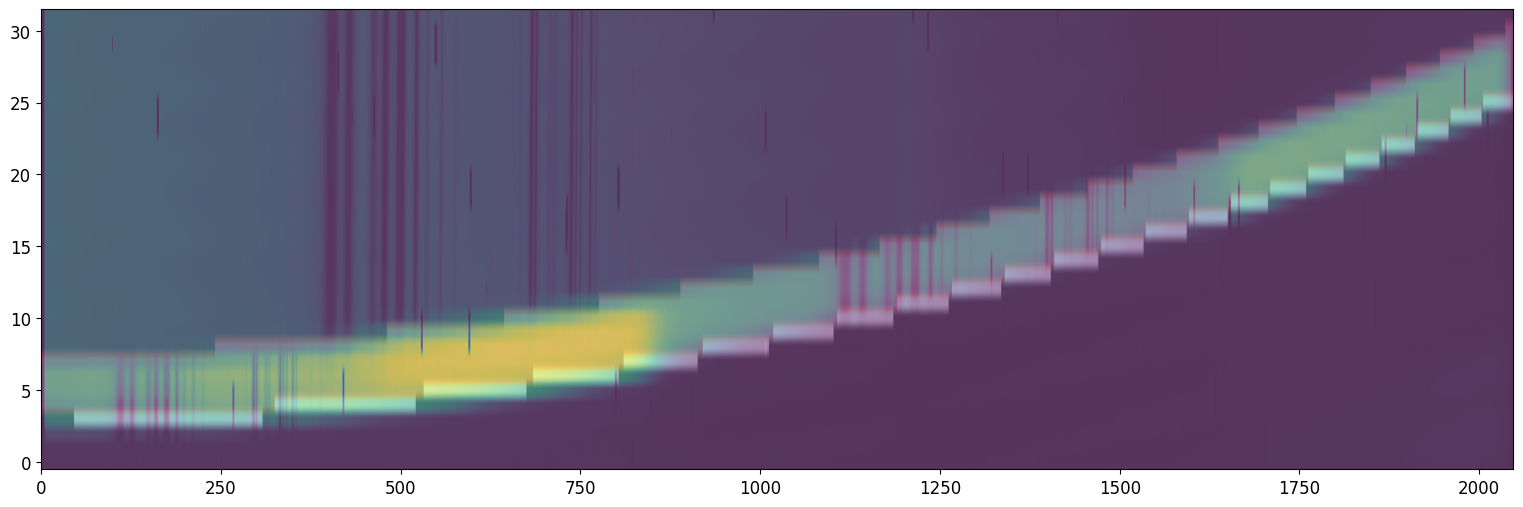


Working with slit/slice:  12


bounding box rounded to next integer:  [[   0 2048]
 [1256 1284]]
Max value in slity array (ignoring NANs):  0.49992178396516856
percentage of F/O trace that was flagged: 100.0


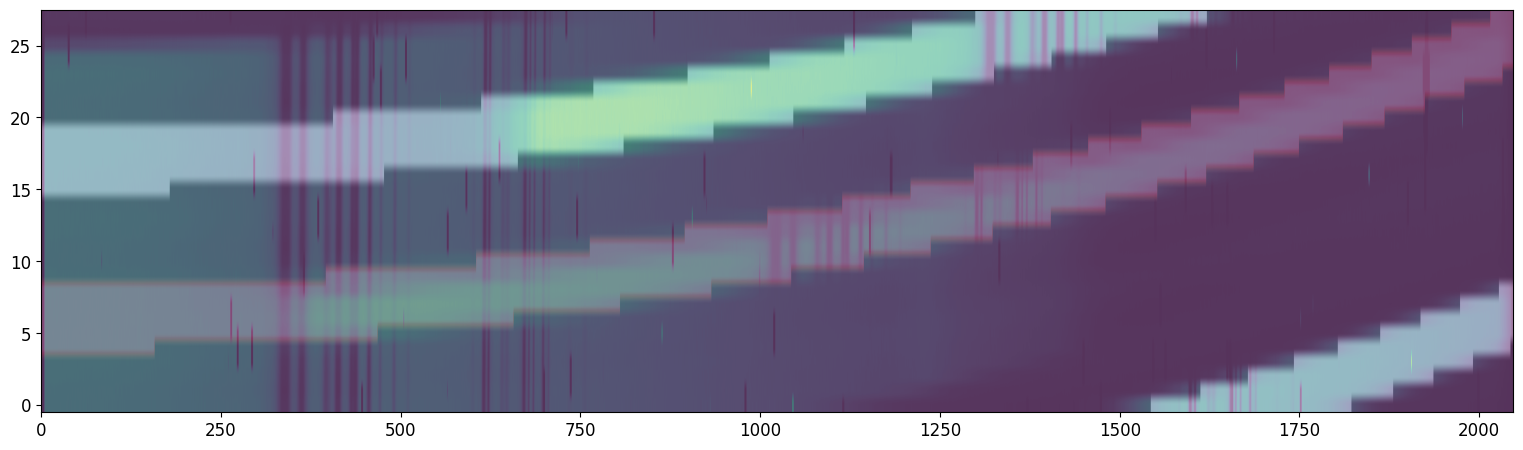


Working with slit/slice:  13


bounding box rounded to next integer:  [[   0 2048]
 [1696 1726]]
Max value in slity array (ignoring NANs):  0.49977105805900096
percentage of F/O trace that was flagged: 100.0


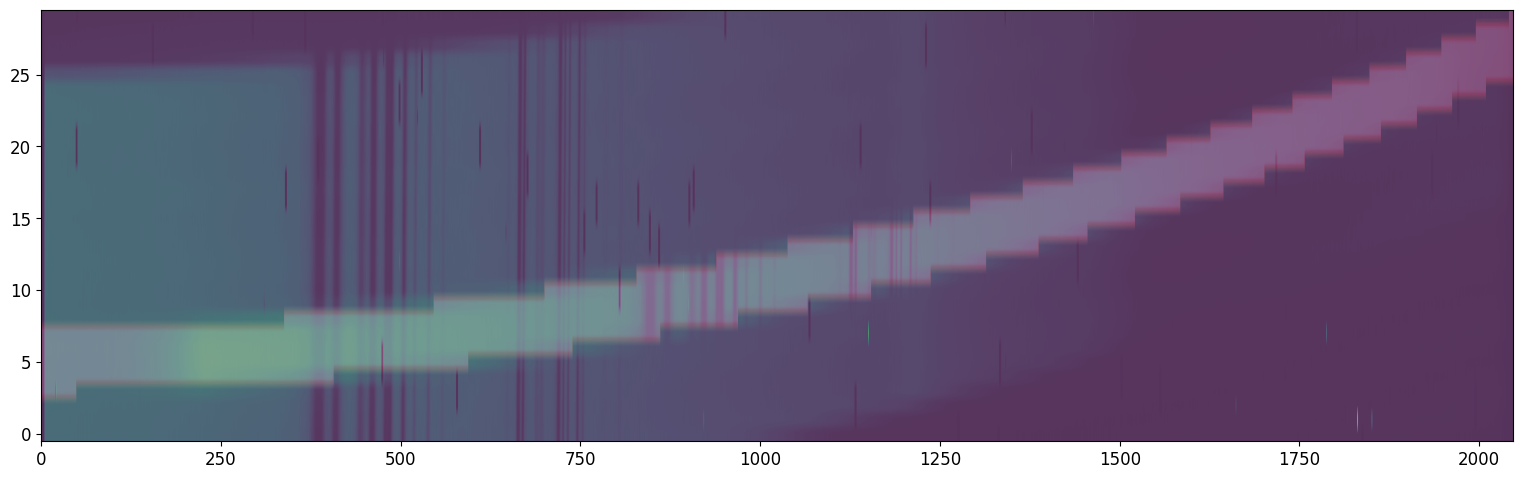


Working with slit/slice:  14


bounding box rounded to next integer:  [[   0 2048]
 [1636 1666]]
Max value in slity array (ignoring NANs):  0.4999166217521449
percentage of F/O trace that was flagged: 100.0


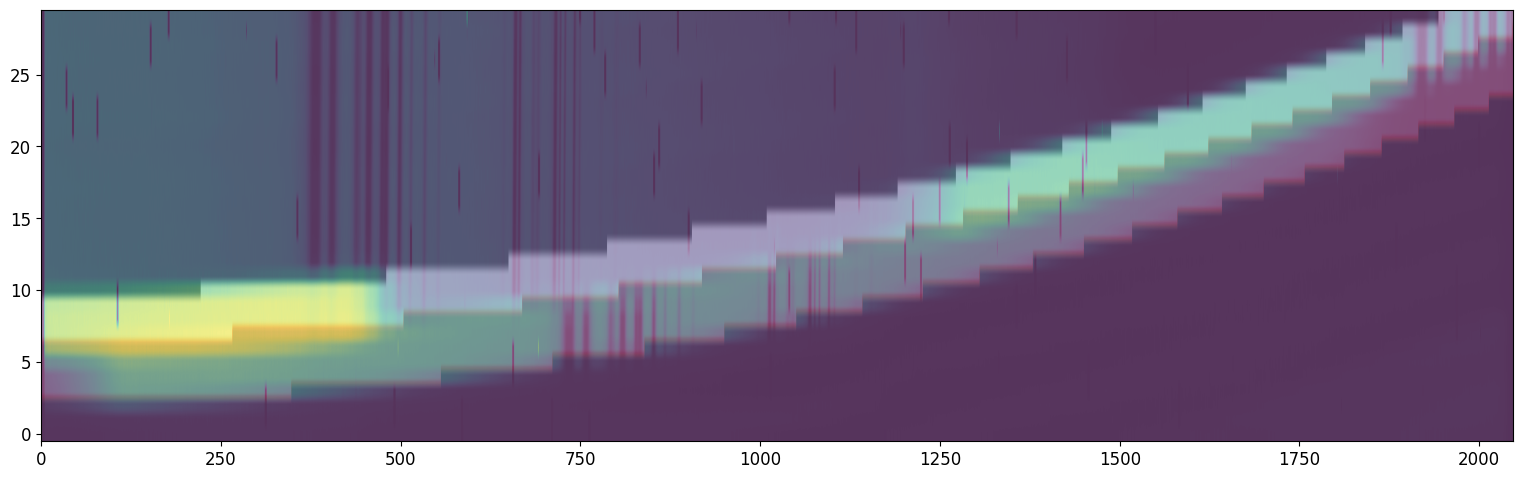


Working with slit/slice:  15


bounding box rounded to next integer:  [[   0 1980]
 [1380 1406]]
Max value in slity array (ignoring NANs):  0.4999679347315006
percentage of F/O trace that was flagged: 100.0


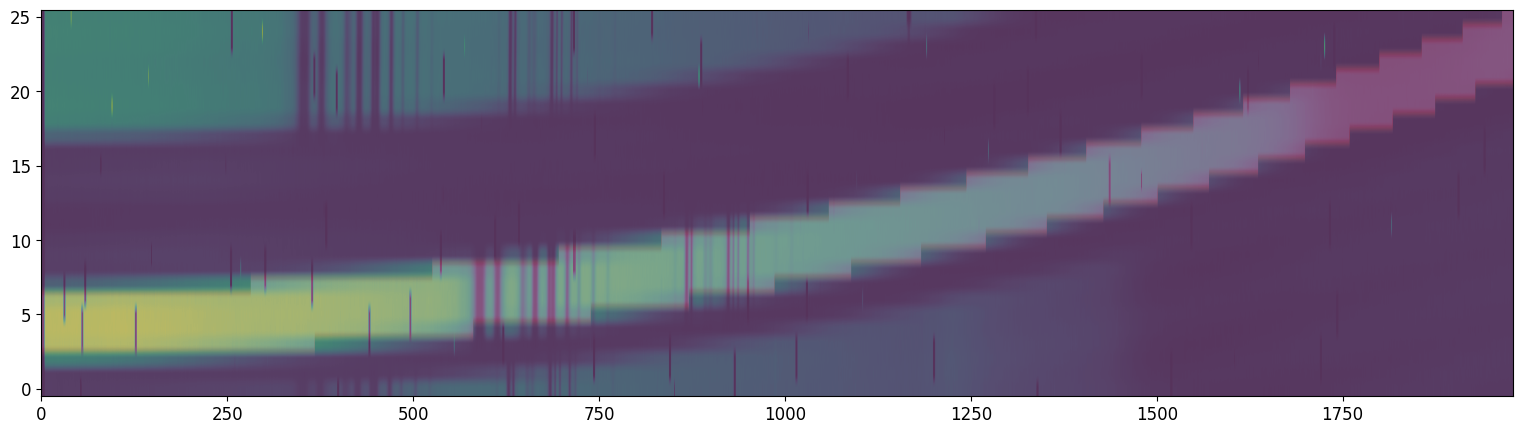


Working with slit/slice:  16


bounding box rounded to next integer:  [[   0 2033]
 [1864 1894]]
Max value in slity array (ignoring NANs):  0.49992408655614395
percentage of F/O trace that was flagged: 100.0


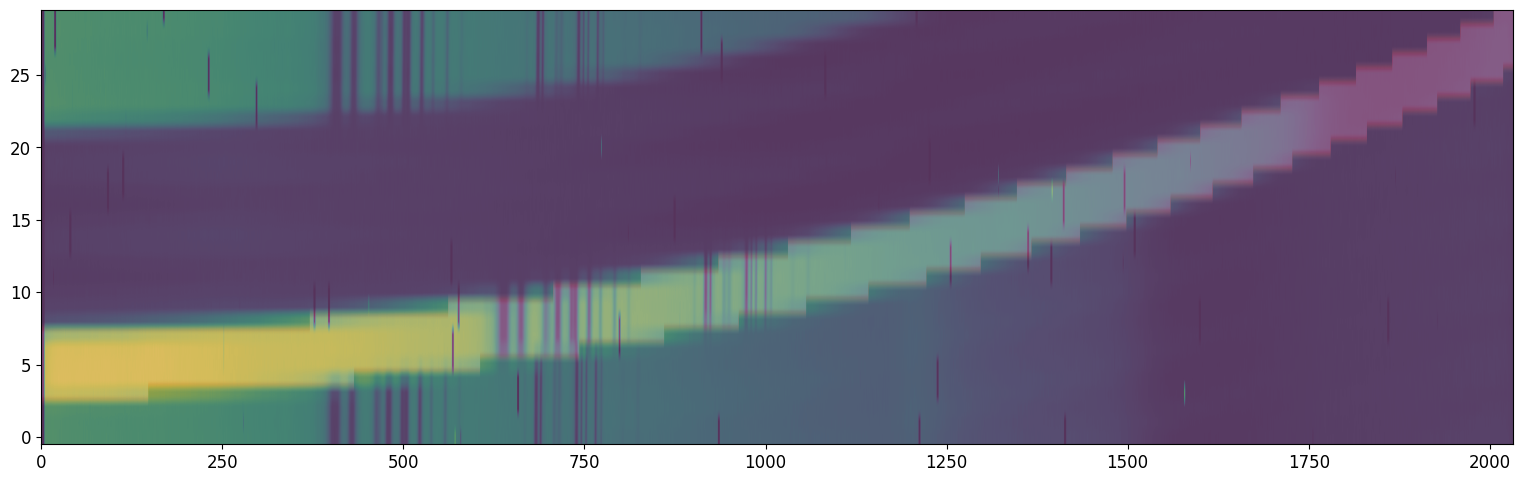


Working with slit/slice:  17


bounding box rounded to next integer:  [[   0 1989]
 [1520 1548]]
Max value in slity array (ignoring NANs):  0.4998243708705976
percentage of F/O trace that was flagged: 100.0


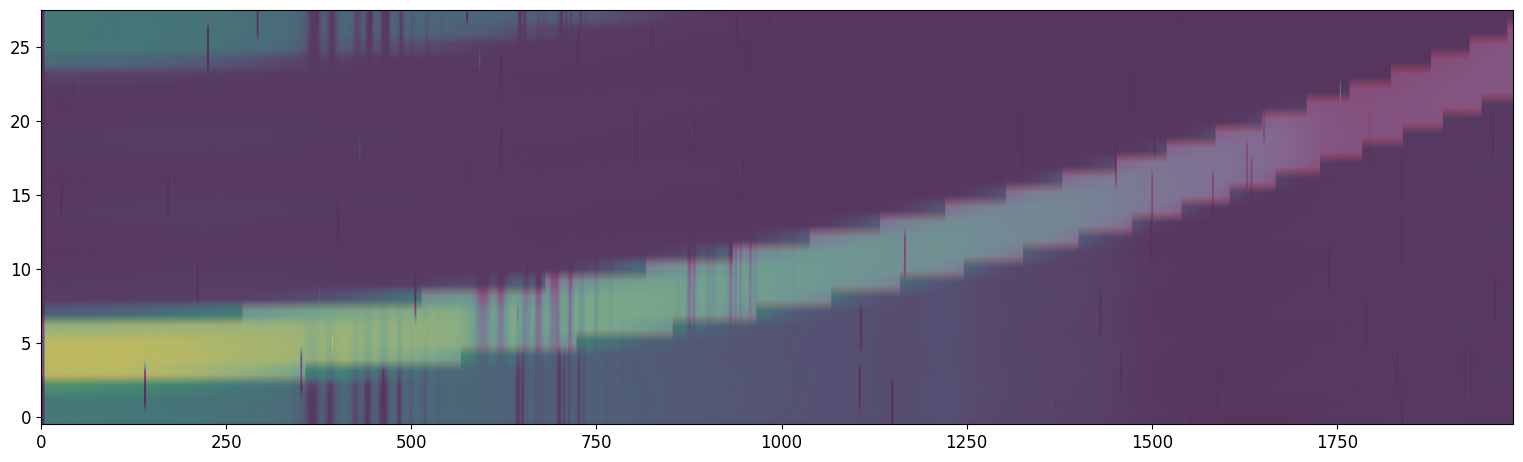


Working with slit/slice:  18


bounding box rounded to next integer:  [[   0 1838]
 [ 208  228]]
Max value in slity array (ignoring NANs):  0.4999277036218135
percentage of F/O trace that was flagged: 100.0


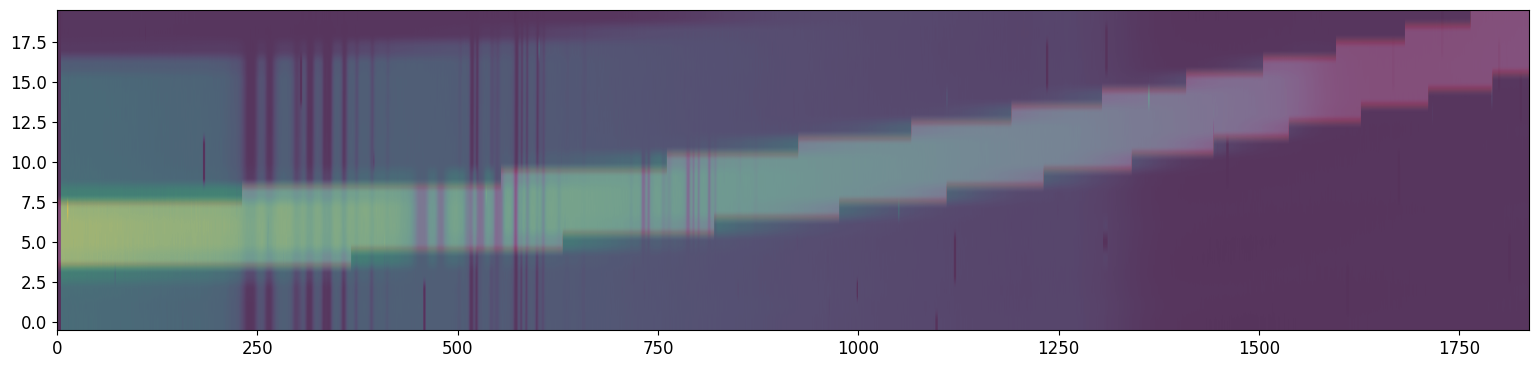


Working with slit/slice:  19


bounding box rounded to next integer:  [[   0 1828]
 [ 626  648]]
Max value in slity array (ignoring NANs):  0.4999228119213873
percentage of F/O trace that was flagged: 100.0


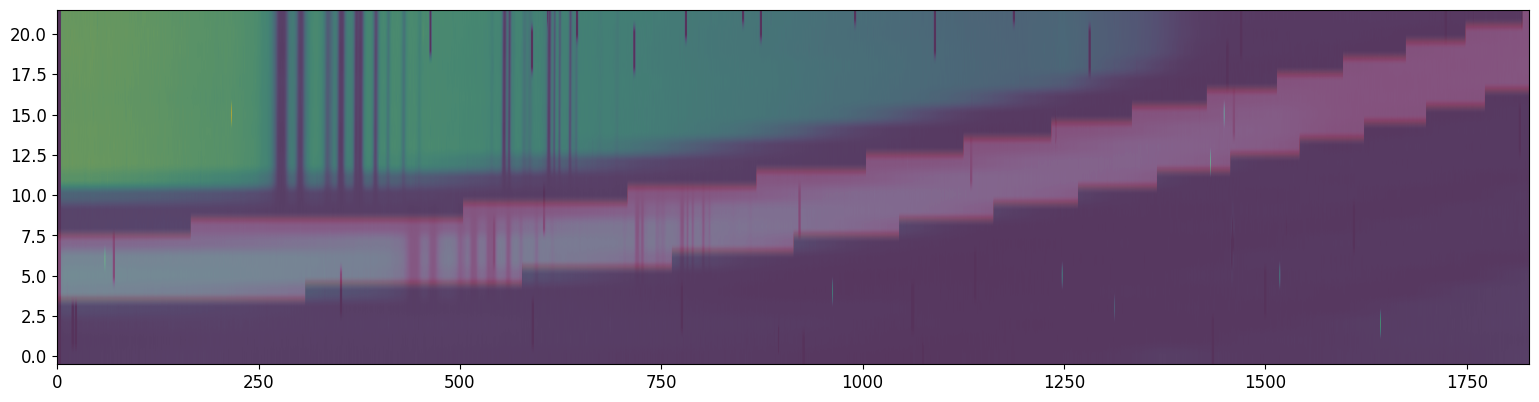


 *** Final result for msa_flagging test will be reported as PASSED *** 

('* MSA flagging validation test took ', '22.350090265274048 seconds to finish.')
Did msa_flagging validation test pass?  True 




In [7]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
msa_flagging_threshold = 99.5

# other NPTT variables
stellarity = None
operability_ref = None
source_type = None
save_figs = False
show_figs = True
debug = False
verbose = False

# Get the data
results_dict = {}
detectors = ['nrs1', 'nrs2']
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
                
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        if msa_shutter_config is not None:
            msa_metadata = rate_object.meta.instrument.msa_metadata_file
            print(msa_metadata)
            if msa_metadata is None or msa_metadata == 'N/A':
                rate_object.meta.instrument.msa_metadata_file = msa_shutter_config

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
            skip_file = False
        except:
            print("An error occured with AssignWcs. Likely: No open slits fall on detector", det)
            print("Skipping test for this file. \n")
            skip_file = True
       
        if not skip_file:
            msa_flagging_object = MSAFlagOpenStep.call(pipe_object)

            # Run the validation test
            %matplotlib inline

            result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.msa_flagging_testing.run_msa_flagging_testing(
                                                                        msa_flagging_object, 
                                                                        msa_flagging_threshold = msa_flagging_threshold,
                                                                        rate_obj = rate_object,
                                                                        stellarity = stellarity, 
                                                                        operability_ref = operability_ref, 
                                                                        save_figs = save_figs, 
                                                                        show_figs = show_figs, 
                                                                        source_type = source_type, 
                                                                        debug = debug)

        else:
            result = 'skipped'


        # Did the test pass
        print("Did msa_flagging validation test pass? ", result, "\n\n")
        rd = {uncal_basename: result}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                if verbose:
                    print('Closing file: ', fd)
                open(fd.fd).close()
            except:
                if verbose:
                    print('File already closed: ', fd)


In [8]:
# Quickly see if the test passed: Do the NIRSpec implementation and the pipeline's agree within <= 99.5%?

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    if not isinstance(val, str):
        if val:
            val = 'PASSED'
        else:
            val = 'FAILED'
    print('{:<40} {:<8}'.format(key, val))


These are the final results of the tests: 
ifu_g395h_f290lp_nrs1_uncal.fits         PASSED  
ifu_g395h_f290lp_nrs2_uncal.fits         PASSED  


# <a id="about_ID"></a>
## About this Notebook
**Authors:** 
- Maria A. Pena-Guerrero, Sr. Science Software Engineer, NIRSpec
- Emily Wislowski, Science Support Analyst I, NIRSpec

<br>**Updated On:** Sep/26/2022

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 